In [1]:
import math
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
data_path = "../data/BOLT Data Set.xlsx"
og_df = pd.read_excel(data_path)

In [305]:
df = og_df.copy()

In [5]:
# df.to_excel("../data_with_dates.xlsx", index=False)

In [306]:
from datetime import datetime
def fix_time(time_str):
    og_time = time_str
    if time_str == "na:n:":
        return np.nan
    try:
        time_str = time_str.replace(":", "").replace(".0", "")
        time_str = '{:0>{}}'.format(time_str, 6)
        time_fixed = datetime.strptime(time_str, '%H%M%S').strftime('%H:%M:%S')
        return time_fixed
    except Exception as e:
        print(e)
        print(og_time)
        return np.nan


In [307]:
# Pre-Processing Columns
df['Transaction Time'] = df['Transaction Time'].apply(fix_time)
df['Transaction Date and Time'] = pd.to_datetime(df['Transaction Date'].astype(str) + ' ' + df['Transaction Time'])
df['Fraud Indicator'] = df['Fraud Indicator (Yes/No)'].map({'Yes': 1, 'No': 0})

In [308]:
fraud = df[df['Fraud Indicator (Yes/No)'] == 'Yes']

In [309]:
df.head()

Card Identifier Transaction Date Transaction Time  Risk Assessment  \
0          card 1       2023-05-11         16:22:14            362.0   
1          card 2       2023-06-05         15:16:35            602.0   
2          card 3       2023-06-05         11:57:40            482.0   
3          card 4       2023-07-20         18:26:30            947.0   
4          card 5       2023-03-03         19:03:11           1382.0   

          Payment Method  Transaction Value Merchant Location  \
0  Paypass - Contactless              13.98               USA   
1                 Online              24.64               USA   
2                Unknown              15.00               USA   
3                 Online              30.56               USA   
4        Magnetic Stripe              50.85               USA   

  Card Present Status Chip Usage Cross-border Transaction (Yes/No)  \
0                  CP        Yes                                No   
1                 CNP         No                                No   
2                 CNP         No                                No   
3                 CNP         No                                No   
4                  CP         No                                No   

  Acquiring Institution ID Merchant Identifier  Merchant Category Code (MCC)  \
0               acquirer 1          merchant 1                        5812.0   
1               acquirer 2          merchant 2                        4121.0   
2               acquirer 3          merchant 3                        7211.0   
3               acquirer 1          merchant 4                        5814.0   
4               acquirer 4          merchant 1                        5812.0   

  Fraud Indicator (Yes/No) Transaction Date and Time  Fraud Indicator  
0                       No       2023-05-11 16:22:14                0  
1                       No       2023-06-05 15:16:35                0  
2                       No       2023-06-05 11:57:40                0  
3                       No       2023-07-20 18:26:30                0  
4                       No       2023-03-03 19:03:11                0

In [10]:
df.describe()

Transaction Date  Risk Assessment  Transaction Value  \
count                         100000     99028.000000      100000.000000   
mean   2023-06-28 20:34:09.120000256       843.157905          71.130702   
min              2023-01-01 00:00:00         2.000000           0.000000   
25%              2023-03-30 00:00:00       352.000000           6.840000   
50%              2023-06-27 00:00:00       592.000000          19.230000   
75%              2023-09-27 00:00:00      1052.000000          50.000000   
max              2023-12-31 00:00:00      4932.000000       15000.000000   
std                              NaN       747.146439         296.637398   

       Merchant Category Code (MCC)      Transaction Date and Time  \
count                  99997.000000                          97963   
mean                    5807.915887  2023-06-29 00:51:40.721476352   
min                      742.000000            2023-01-01 00:26:59   
25%                     5411.000000            2023-03-30 17:21:35   
50%                     5812.000000            2023-06-27 12:14:39   
75%                     5942.000000     2023-09-26 19:01:10.500000   
max                     9999.000000            2023-12-31 23:55:55   
std                     1061.918829                            NaN   

       Fraud Indicator  
count     100000.00000  
mean           0.00265  
min            0.00000  
25%            0.00000  
50%            0.00000  
75%            0.00000  
max            1.00000  
std            0.05141

## Build Graph

In [183]:
from sklearn.utils import resample

df_majority = df[df['Fraud Indicator'] == 0]
df_minority = df[df['Fraud Indicator'] == 1]

df_maj_downsampled = resample(df_majority, n_samples=2000, random_state=42)
df_downsampled = pd.concat([df_minority, df_maj_downsampled])

In [184]:
df_downsampled['Fraud Indicator'].value_counts()

Fraud Indicator
0    2000
1     265
Name: count, dtype: int64

In [185]:
print( df_downsampled["Card Identifier"].nunique(), df_downsampled["Merchant Identifier"].nunique() )

1452 497


In [14]:
def build_graph_bipartite(df_input, graph_type=nx.Graph()):
    df = df_input.copy()
    mapping = {x:node_id for node_id, x in enumerate(set(df["Card Identifier"].values.tolist() + df["Merchant Identifier"].values.tolist()))}
    
    df["from"] = df["Card Identifier"].apply(lambda x: mapping[x])
    df["to"] = df["Merchant Identifier"].apply(lambda x: mapping[x])
    
    df = df[["from", "to", "Transaction Value", "Fraud Indicator"]].groupby(['from', 'to']).agg({"Fraud Indicator": sum, "Transaction Value": sum}).reset_index()
    
    df["Fraud Indicator"] = df["Fraud Indicator"].apply(lambda x: 1 if x>0 else 0)
    
    G = nx.from_edgelist(df[["from", "to"]].values, create_using=graph_type)
    nx.set_edge_attributes(G, {(int(x["from"]), \
                               int(x["to"])):x["Fraud Indicator"] \
                               for idx, x in \
                               df[["from", "to", "Fraud Indicator"]].iterrows()},
                           "label")
    
    nx.set_edge_attributes(G, {(int(x["from"]), \
                               int(x["to"])):x["Transaction Value"] \
                               for idx, x in \
                               df[["from", "to", "Transaction Value"]].iterrows()},
                           "weight")
    return G, mapping

In [16]:
def build_graph_tripartite(df_input, graph_type=nx.Graph()):
    df = df_input.copy()
    mapping = {x:node_id for node_id,x in enumerate(set(df.index.values.tolist() + 
                                                        df["Card Identifier"].values.tolist() + 
                                                        df["Merchant Identifier"].values.tolist()))}
    df["in_node"] = df["Card Identifier"].apply(lambda x: mapping[x])
    df["out_node"] = df["Merchant Identifier"].apply(lambda x: mapping[x])

    G = nx.from_edgelist([(x["in_node"], mapping[idx]) for idx, x in df.iterrows()] +
                         [(x["out_node"], mapping[idx]) for idx, x in df.iterrows()], 
                         create_using=graph_type)

    nx.set_node_attributes(G,{x["in_node"]:1 for idx,x in df.iterrows()}, "bipartite")
    nx.set_node_attributes(G,{x["out_node"]:2 for idx,x in df.iterrows()}, "bipartite")
    nx.set_node_attributes(G,{mapping[idx]:3 for idx, x in df.iterrows()}, "bipartite")

    nx.set_edge_attributes(G,{(x["in_node"], mapping[idx]):x["Fraud Indicator"] for idx, x in df.iterrows()}, "label")
    nx.set_edge_attributes(G,{(x["out_node"], mapping[idx]):x["Fraud Indicator"] for idx, x in df.iterrows()}, "label")

    nx.set_edge_attributes(G,{(x["in_node"], mapping[idx]):x["Transaction Value"] for idx, x in df.iterrows()}, "weight")
    nx.set_edge_attributes(G,{(x["out_node"], mapping[idx]):x["Transaction Value"] for idx, x in df.iterrows()}, "weight")
    return G, mapping

In [258]:
# Directed Graph
G_bu, bi_mapping = build_graph_bipartite(df_downsampled, nx.Graph(name="Bipartite Undirected"))
# # Directed Graph
# G_bd, _ = build_graph_bipartite(df, nx.DiGraph(name="Bipartite Directed"))

C:\Users\simon\AppData\Local\Temp\ipykernel_21728\4270206850.py:8: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'sum' instead.
  df = df[["from", "to", "Transaction Value", "Fraud Indicator"]].groupby(['from', 'to']).agg({"Fraud Indicator": sum, "Transaction Value": sum}).reset_index()


In [259]:
G_tu, tri_mapping = build_graph_tripartite(df_downsampled, nx.Graph(name="Tripartite Undirected"))
# G_td = build_graph_tripartite(df_downsampled, nx.DiGraph(name="Tripartite Directed"))


In [260]:
from networkx.algorithms import bipartite
bipartite.is_bipartite(G_bu) == bipartite.is_bipartite(G_bd) == True


True

In [261]:
print(G_bu)

Graph with 1949 nodes and 2107 edges


Text(0.5, 1.0, 'Tripartite Nodes Degree Distribution')

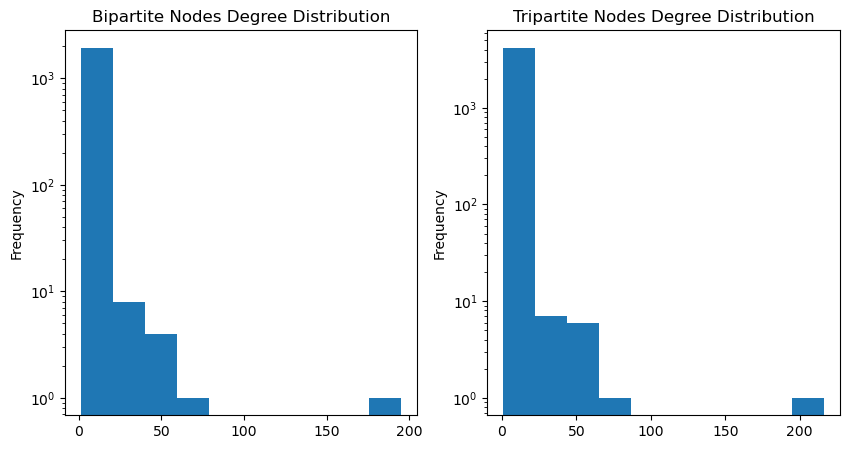

In [262]:
plt.figure(figsize=(10,5))
degrees = pd.Series(
    {
        k:v for k,v in nx.degree(G_bu)
    }
)
plt.subplot(1,2,1)
degrees.plot(kind="hist")
plt.yscale("log")
plt.title("Bipartite Nodes Degree Distribution")

# plt.figure(figsize=(10,10))
degrees = pd.Series(
    {
        k:v for k,v in nx.degree(G_tu)
    }
)
plt.subplot(1,2,2)
degrees.plot(kind="hist")
plt.yscale("log")
plt.title("Tripartite Nodes Degree Distribution")

Text(0.5, 1.0, 'Tripartite Edges Weight Distribution')

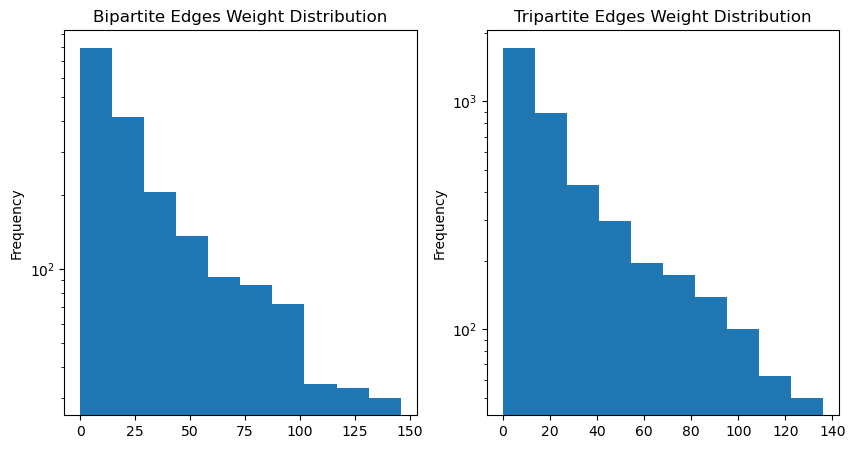

In [263]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
allEdgesWeights = pd.Series({(d[0], d[1]): d[2]["weight"] for d in G_bu.edges(data=True)})
np.quantile(allEdgesWeights.values,[0.10, 0.50, 0.70, 0.90])
quant_dist = np.quantile(allEdgesWeights.values, [0.10, 0.50, 0.70, 0.90])
allEdgesWeightsFiltered = pd.Series({(d[0], d[1]): d[2]["weight"] for d in G_bu.edges(data=True)
                                if d[2]["weight"] < quant_dist[-1]})
allEdgesWeightsFiltered.plot(kind="hist")
plt.yscale("log")
plt.title("Bipartite Edges Weight Distribution")

plt.subplot(1,2,2)
allEdgesWeights = pd.Series({(d[0], d[1]): d[2]["weight"] for d in G_tu.edges(data=True)})
np.quantile(allEdgesWeights.values,[0.10, 0.50, 0.70, 0.90])
quant_dist = np.quantile(allEdgesWeights.values, [0.10, 0.50, 0.70, 0.90])
allEdgesWeightsFiltered = pd.Series({(d[0], d[1]): d[2]["weight"] for d in G_tu.edges(data=True)
                                if d[2]["weight"] < quant_dist[-1]})
allEdgesWeightsFiltered.plot(kind="hist")
plt.yscale("log")
plt.title("Tripartite Edges Weight Distribution")

In [264]:
import community

parts = community.best_partition(G_bu, random_state=42, weight="weight")
bi_communities = pd.Series(parts)
print("Bipartite communities sorted by order of complexity")
bi_communities.value_counts().sort_values(ascending=False)

Bipartite communities sorted by order of complexity


0      203
5      115
28      79
117     72
41      67
13      60
7       60
22      55
48      54
45      48
4       46
10      39
3       39
62      37
34      33
40      31
25      31
8       26
9       24
52      19
31      19
33      18
23      18
99      18
36      17
112     16
38      15
190     15
21      14
104     13
44      13
106     13
175     13
97      12
85      10
87      10
78       9
24       9
53       9
67       8
17       8
39       8
80       6
141      6
98       6
137      5
59       5
58       5
42       5
187      5
134      4
107      4
147      4
197      4
15       4
171      4
18       4
11       4
54       4
77       3
169      3
69       3
57       3
37       3
72       3
55       3
115      3
1        3
75       3
81       3
27       3
26       3
20       3
83       3
121      3
168      3
249      3
181      3
130      3
88       3
89       3
96       3
172      3
161      3
126      3
260      3
105      3
222      3
216      3
150      3
194      3

In [265]:
import community

parts = community.best_partition(G_tu, random_state=42, weight="weight")
tri_communities = pd.Series(parts)
print("Tripartite communities sorted by order of complexity")
tri_communities.value_counts().sort_values(ascending=False)

Tripartite communities sorted by order of complexity


3      389
15     149
54     142
9      135
36     131
16     126
35     117
48     112
14      87
5       84
45      81
27      80
68      76
41      74
46      72
78      72
8       69
18      68
25      62
24      61
7       60
65      57
40      56
33      49
60      45
1       40
26      39
21      38
72      37
76      37
30      37
37      31
22      30
142     30
57      30
0       29
123     26
93      25
23      25
29      24
145     21
84      21
44      20
66      20
56      19
2       19
69      18
61      18
77      17
12      17
53      17
42      16
196     13
96      13
252     12
47      12
284     11
104     11
171     11
55      10
266      9
74       9
39       9
85       9
182      8
138      8
114      8
13       8
75       8
59       8
270      8
100      7
179      7
51       7
62       7
32       7
351      7
193      7
135      7
49       7
128      6
185      6
11       6
88       6
118      6
80       6
58       5
158      5
385      5
343      5
301      5

Text(0, 0.5, 'Frequency')

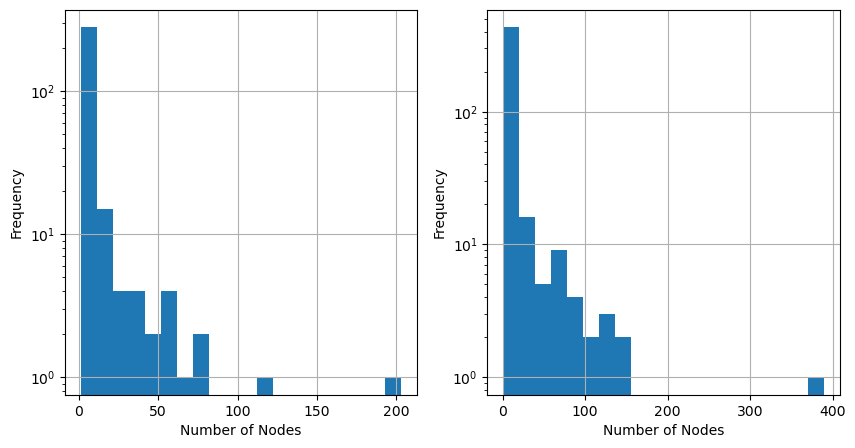

In [266]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
bi_communities.value_counts().hist(bins=20);
plt.yscale("log")

plt.xlabel("Number of Nodes")
plt.ylabel("Frequency")

plt.subplot(1,2,2)
tri_communities.value_counts().hist(bins=20);
plt.yscale("log")

plt.xlabel("Number of Nodes")
plt.ylabel("Frequency")

In [267]:
bi_communities.nunique()

314

In [268]:
tri_communities.nunique()

473

In [269]:
# Ratio of fradulent / benign nodes in communities
def get_subgraphs(G, communities):
    graphs = {}
    d = {}
    for x in communities.unique():
        tmp = nx.subgraph(G, communities[communities==x].index)
        fraud_edges = sum(nx.get_edge_attributes(tmp, "label").values())
        ratio = 0 if fraud_edges == 0 else (fraud_edges/tmp.number_of_edges())*100
        d[x] = ratio
        graphs[x] = tmp

    return graphs, d

In [270]:
bi_graphs, bi_ratios = get_subgraphs(G_bu, bi_communities)
pd.set_option('display.max_rows', 500)
pd.Series(bi_ratios).sort_values(ascending=False).head(60)
# pd.set_option('display.max_rows', 100)

121    100.000000
15     100.000000
49     100.000000
303    100.000000
37     100.000000
55     100.000000
150    100.000000
282    100.000000
276    100.000000
89     100.000000
234    100.000000
94     100.000000
50     100.000000
95     100.000000
136    100.000000
269    100.000000
126    100.000000
135    100.000000
186    100.000000
171    100.000000
97      90.909091
98      80.000000
58      75.000000
134     66.666667
194     50.000000
34      43.750000
190     42.857143
175     41.666667
85      33.333333
25      30.000000
53      25.000000
22      22.222222
45      17.021277
44      16.666667
31      16.666667
10      15.384615
48      14.814815
38      14.285714
67      14.285714
7       13.559322
62      13.513514
40      13.333333
28      12.820513
24      12.500000
78      12.500000
87      11.111111
117     10.958904
3       10.526316
13       8.474576
106      8.333333
0        7.729469
36       6.250000
23       5.882353
52       5.555556
4        4.444444
41       3

In [271]:
tri_graphs, tri_ratios = get_subgraphs(G_tu, tri_communities)
pd.set_option('display.max_rows', 500)
pd.Series(tri_ratios).sort_values(ascending=False).head(60)
# pd.set_option('display.max_rows', 100)

58    100.000000
11    100.000000
31    100.000000
34    100.000000
20    100.000000
19    100.000000
43    100.000000
17    100.000000
49    100.000000
51    100.000000
50    100.000000
10    100.000000
6     100.000000
67    100.000000
64    100.000000
52    100.000000
63    100.000000
4     100.000000
28    100.000000
29     91.666667
59     85.714286
32     85.714286
47     83.333333
39     75.000000
13     75.000000
55     66.666667
23     56.000000
38     50.000000
30     47.500000
0      42.857143
24     41.935484
53     37.500000
42     37.500000
41     33.333333
56     33.333333
62     33.333333
33     32.653061
2      30.000000
61     29.411765
25     28.787879
44     28.571429
26     18.421053
7      18.032787
9      16.783217
40     16.071429
35     15.126050
14     14.444444
57     13.793103
18     13.432836
37     13.333333
16     13.178295
8      12.857143
5      12.500000
12     12.500000
66     10.526316
45      8.641975
22      6.666667
36      6.060606
48      5.8333

In [390]:
def plot_community(graphs, ratios, mapping, gId):
    reversed_mapping = {v:k for k,v in mapping.items()}

    plt.figure(figsize=(16,14))
    spring_pos = nx.spring_layout(graphs[gId])
    plt.axis("off")
    edge_colors = ["r" if x == 1 else "g" for x in nx.get_edge_attributes(graphs[gId], 'label').values()]
    node_colors = []
    labels = {}
    for node in nx.nodes(graphs[gId]):
        id = reversed_mapping[node]
        labels[node] = id
        if type(id) == int:
            date_time = str(df_downsampled.loc[id]["Transaction Date and Time"])[5:] #cut off year
            transaction_value = str(df_downsampled.loc[id]["Transaction Value"])
            labels[node] = transaction_value + " @" + date_time
            node_colors.append("y")
        else:
            labels[node] = id
            if id.startswith("card"):
                node_colors.append("b")
            elif id.startswith("merchant"):
                node_colors.append("c")
    nx.draw_networkx(graphs[gId], pos=spring_pos, node_color=node_colors, edge_color=edge_colors, with_labels=False, node_size=1000)
    pos_higher = {}
    y_off = 0.03  # offset on the y axis
    x_off = 0.03

    for k, v in spring_pos.items():
        pos_higher[k] = (v[0] + x_off, v[1] - y_off)


    # nx.draw_networkx_labels(graphs[gId], pos_higher, labels, font_size=22, font_color="#303030")

    fraud_ratio = ratios[gId]
    plt.title(f"Community {gId} - Fraudulent Ratio = {fraud_ratio}")
    plt.show()

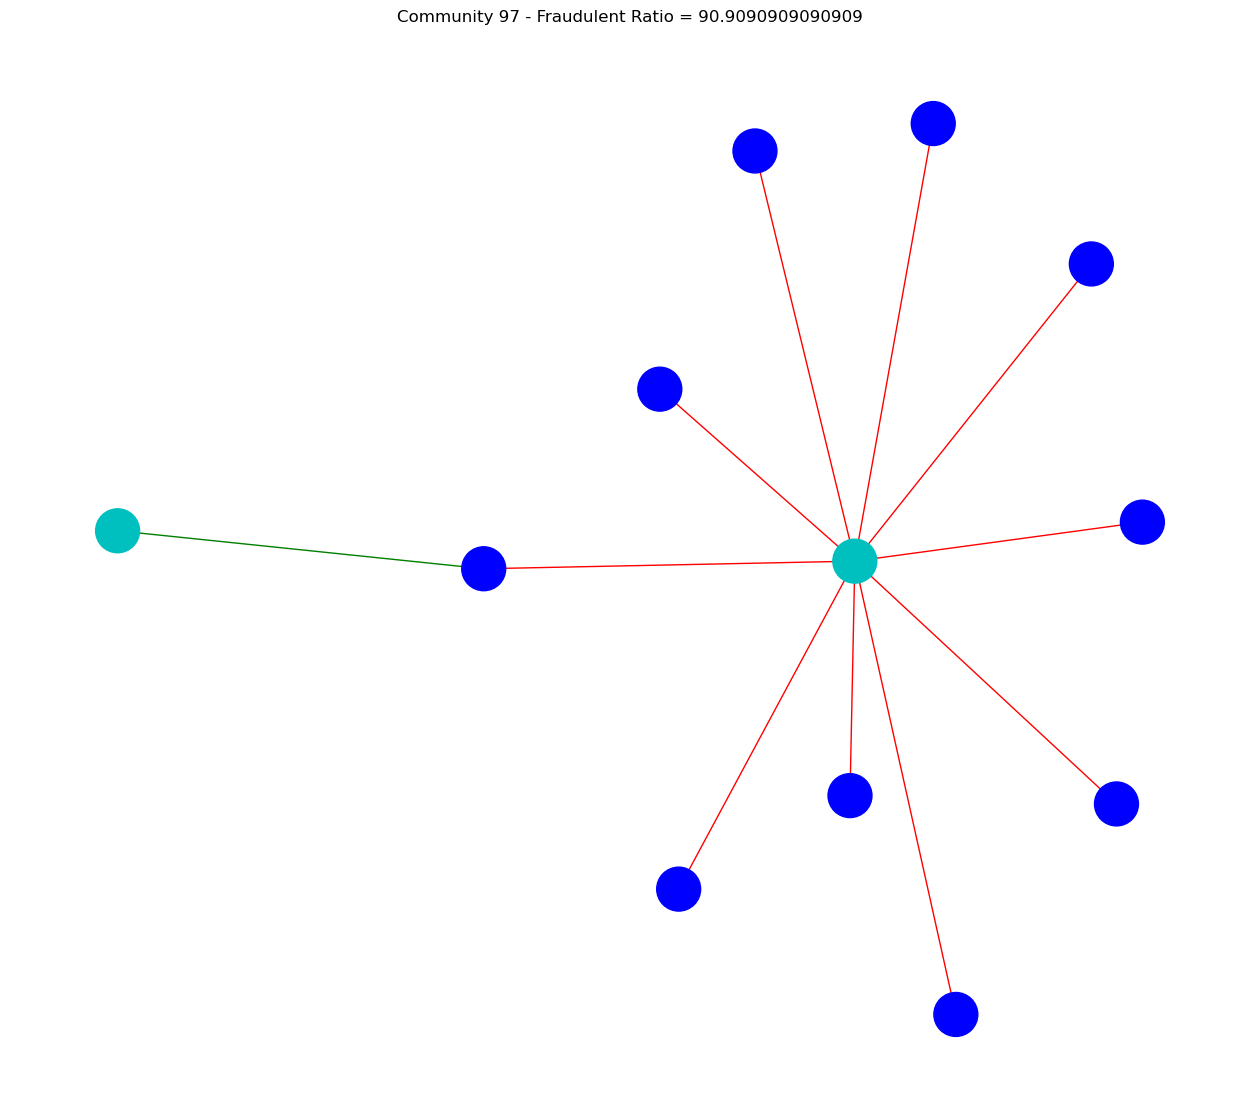

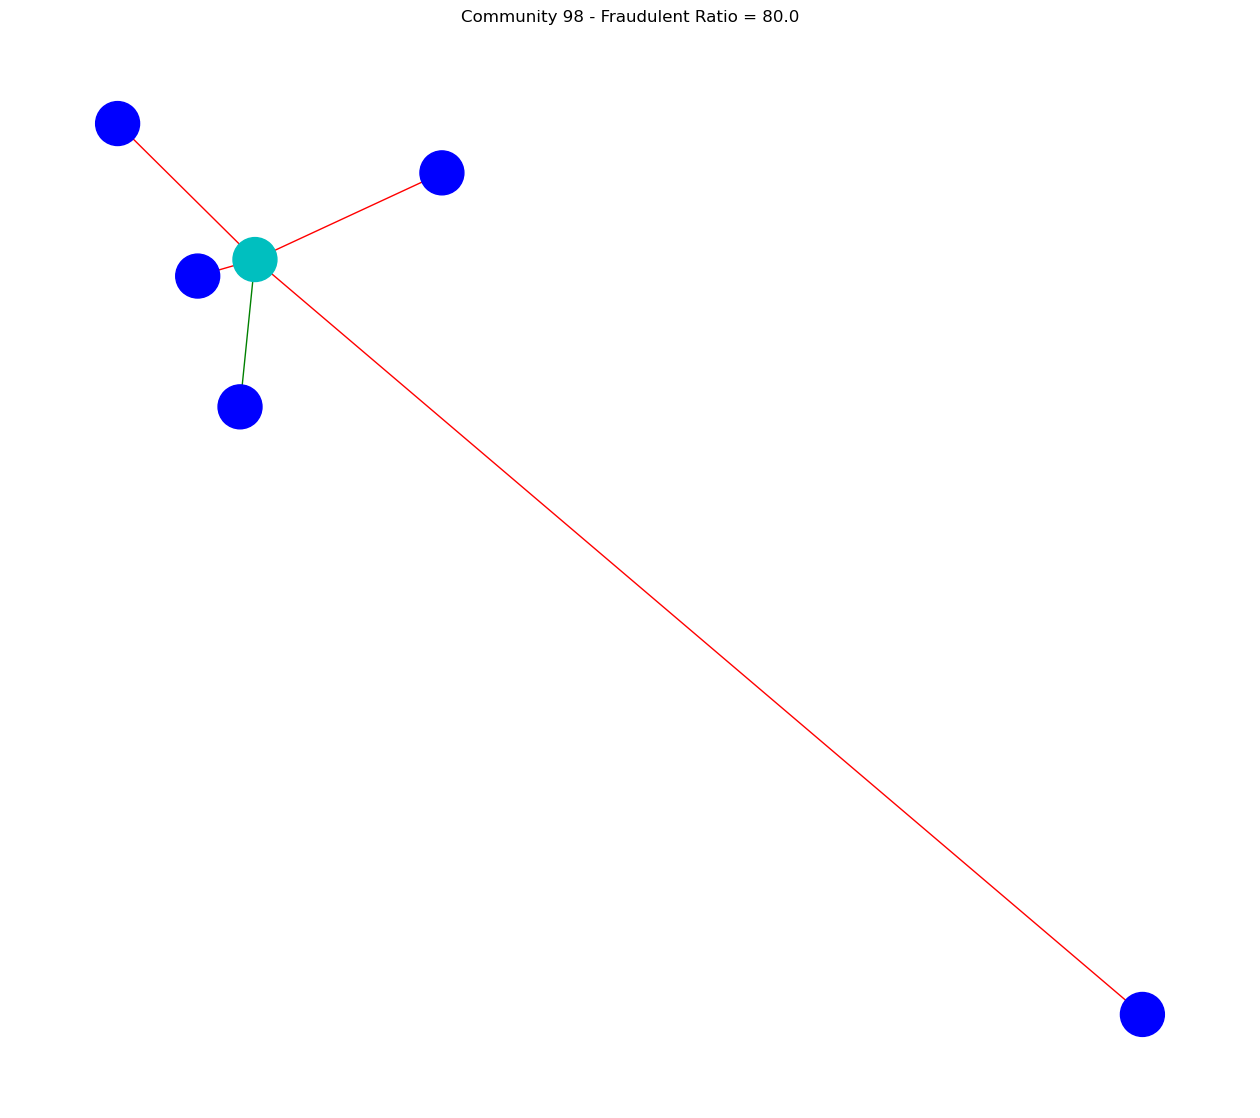

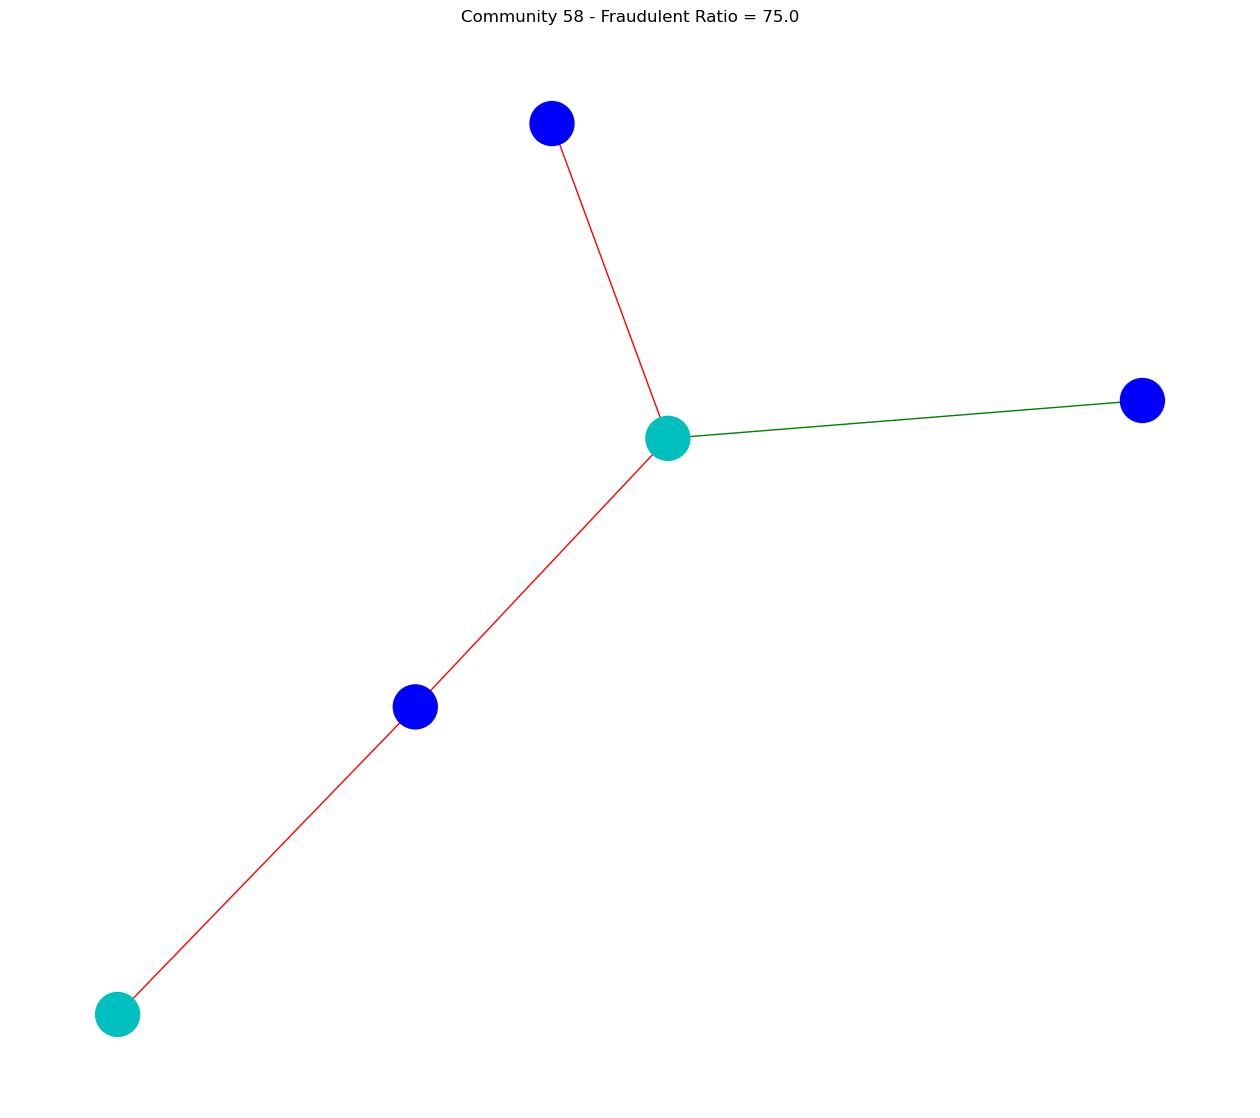

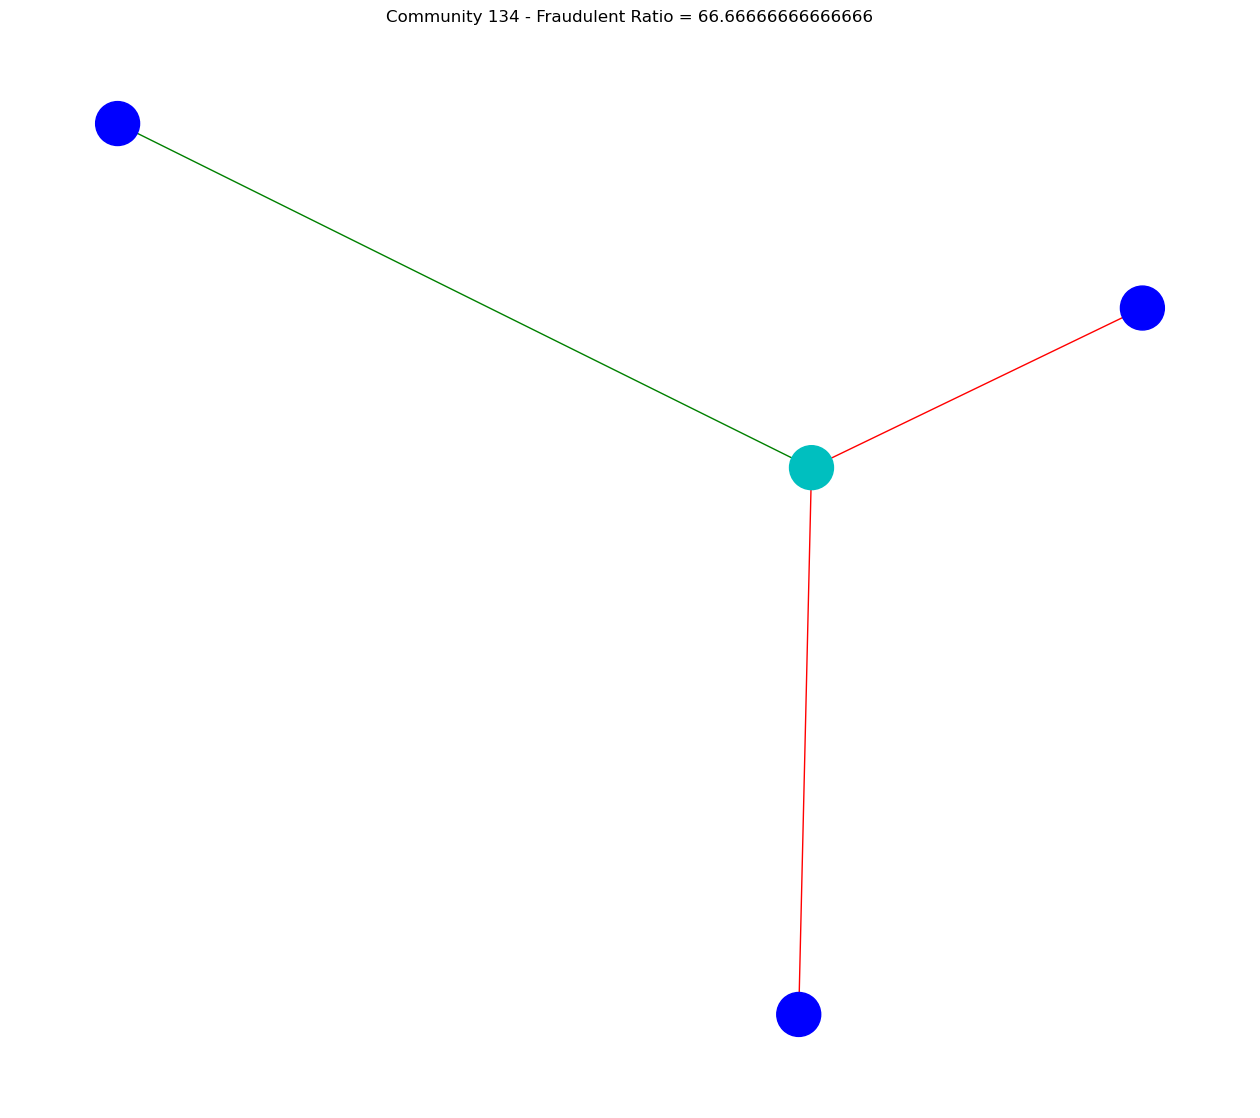

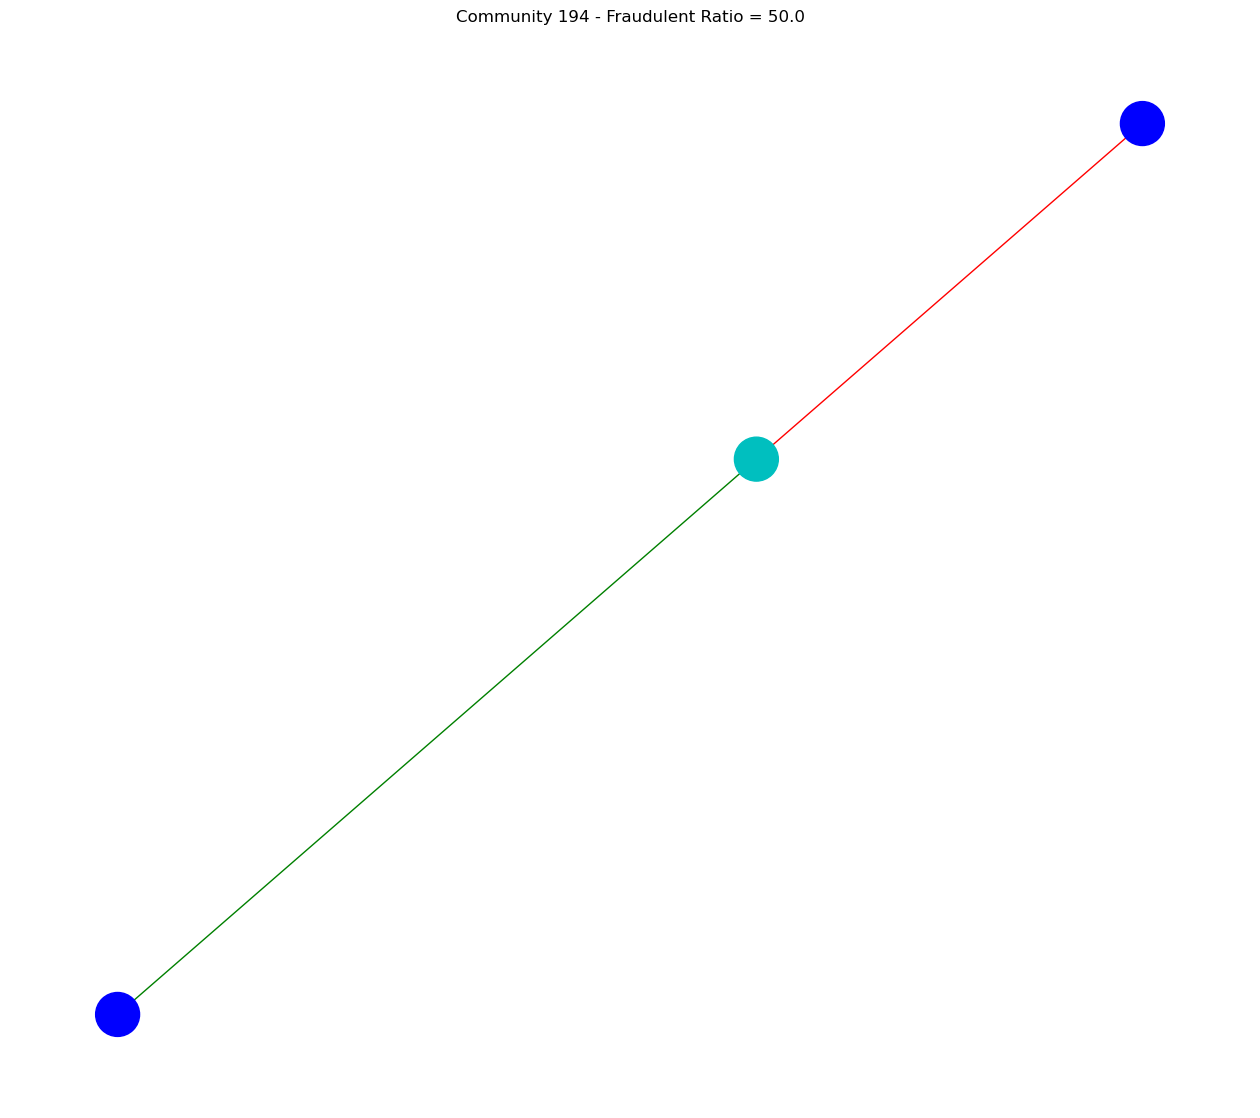

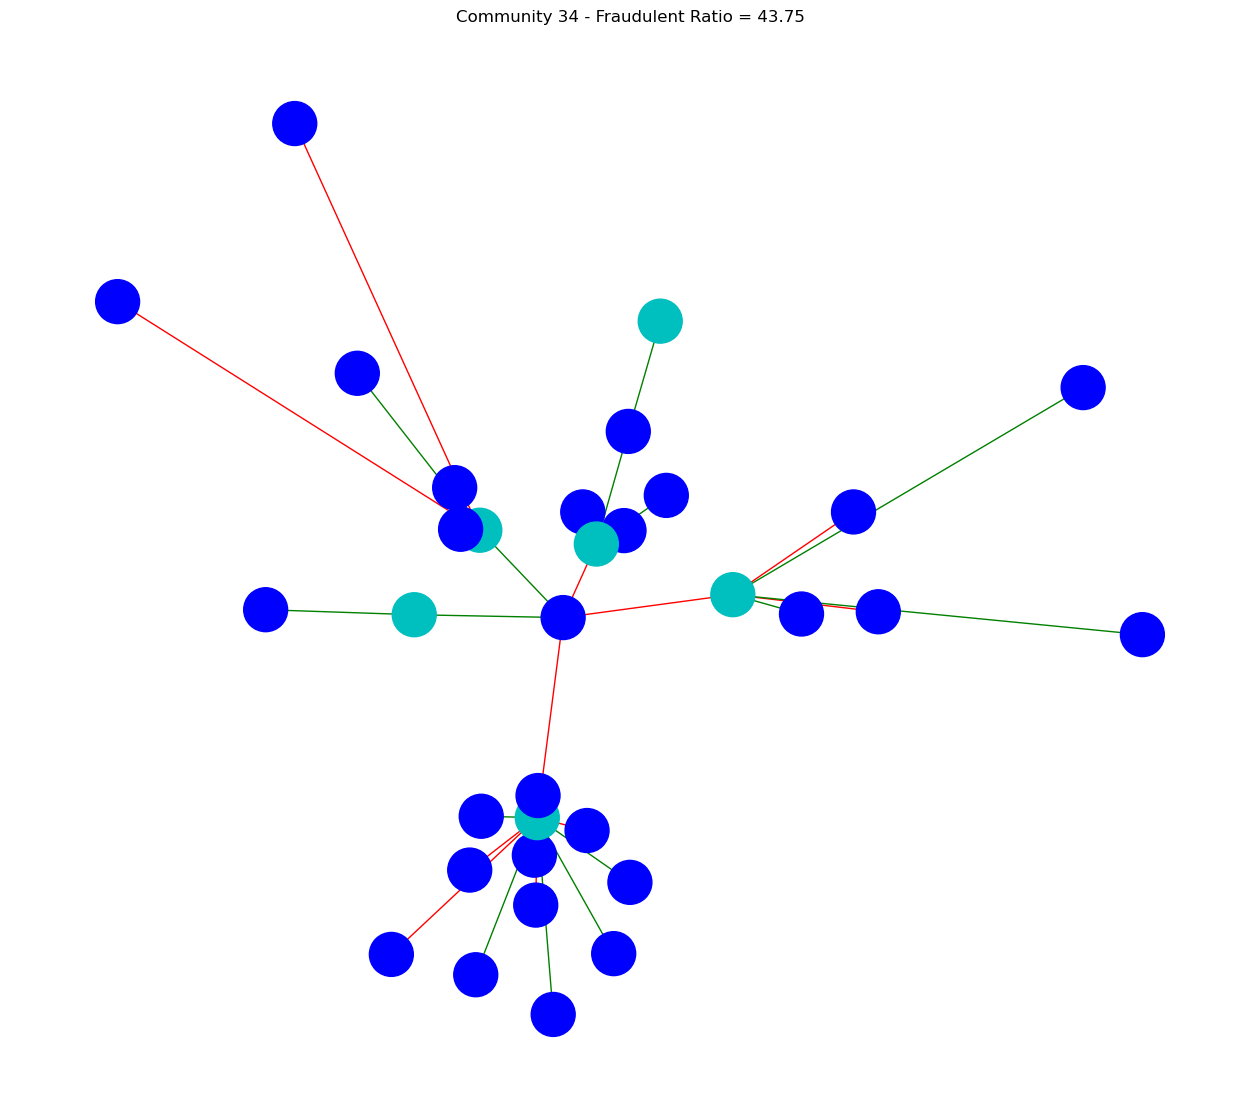

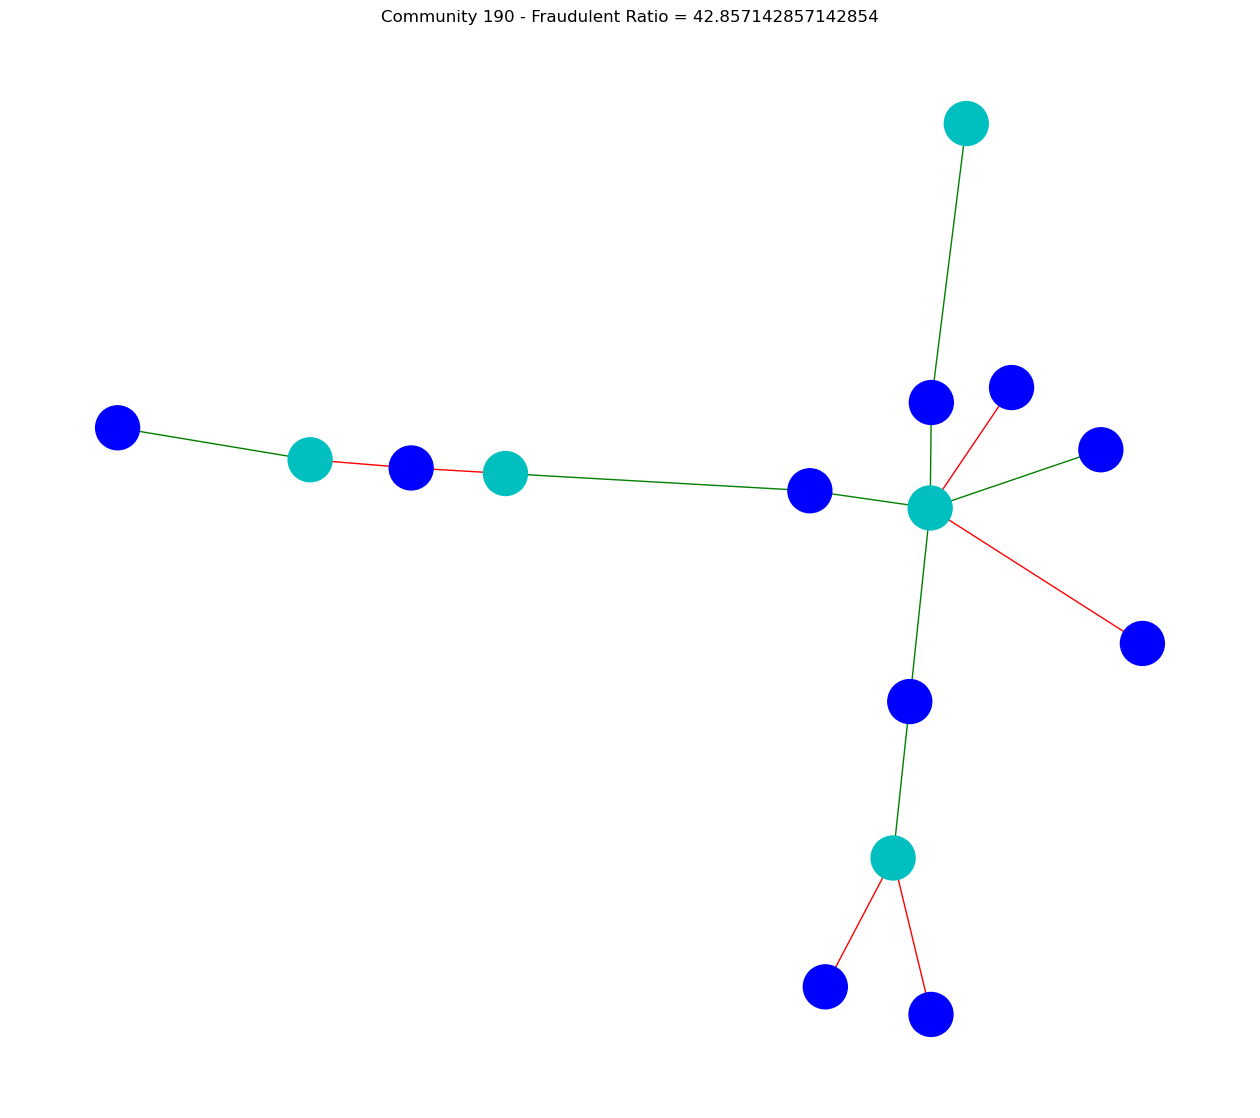

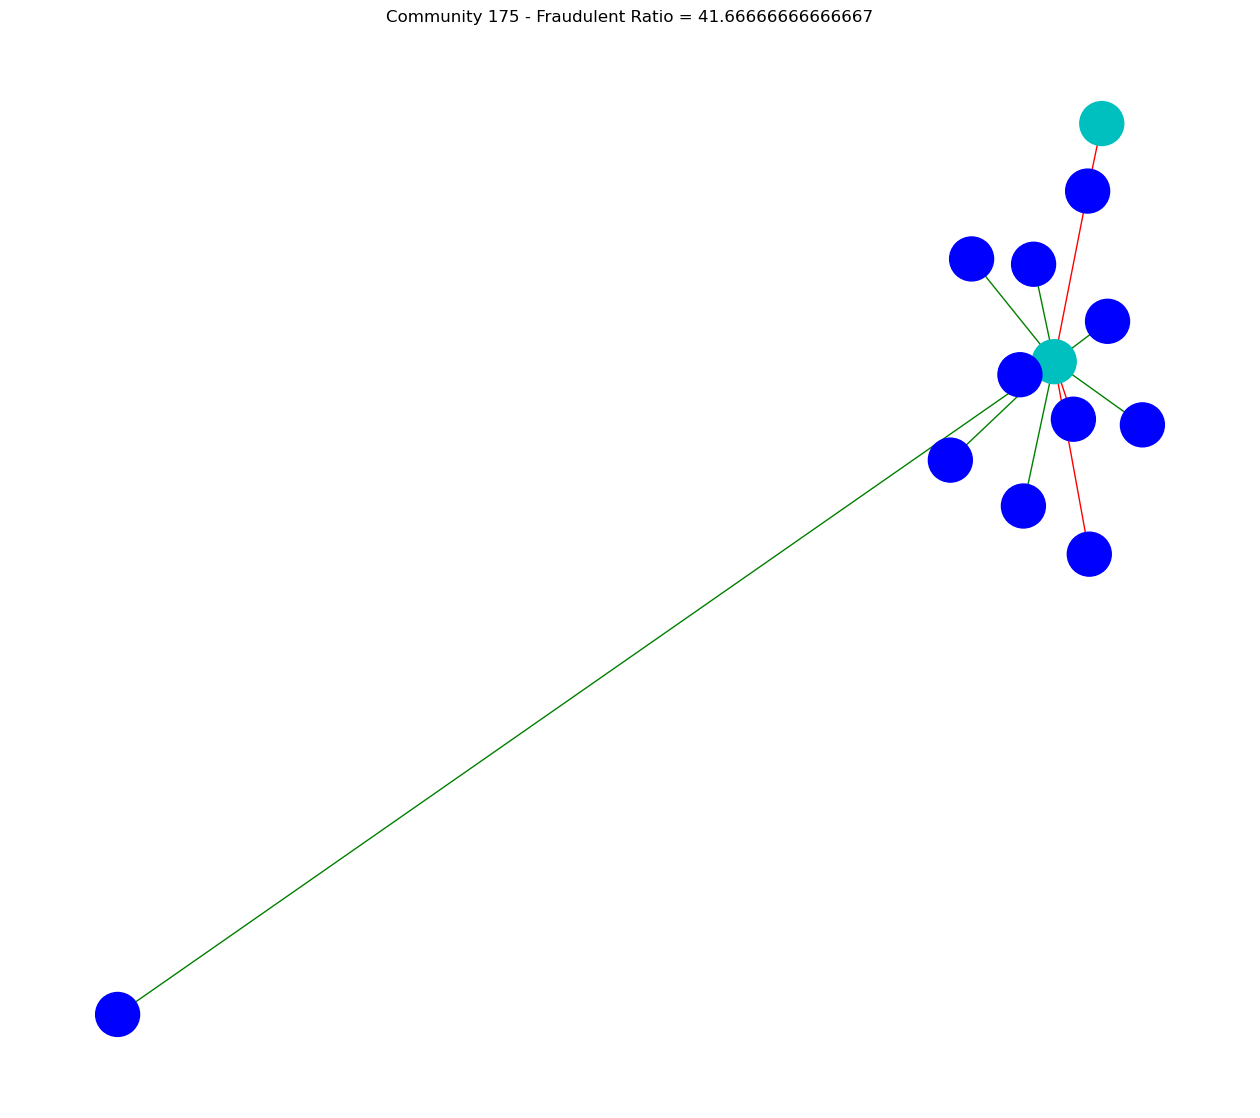

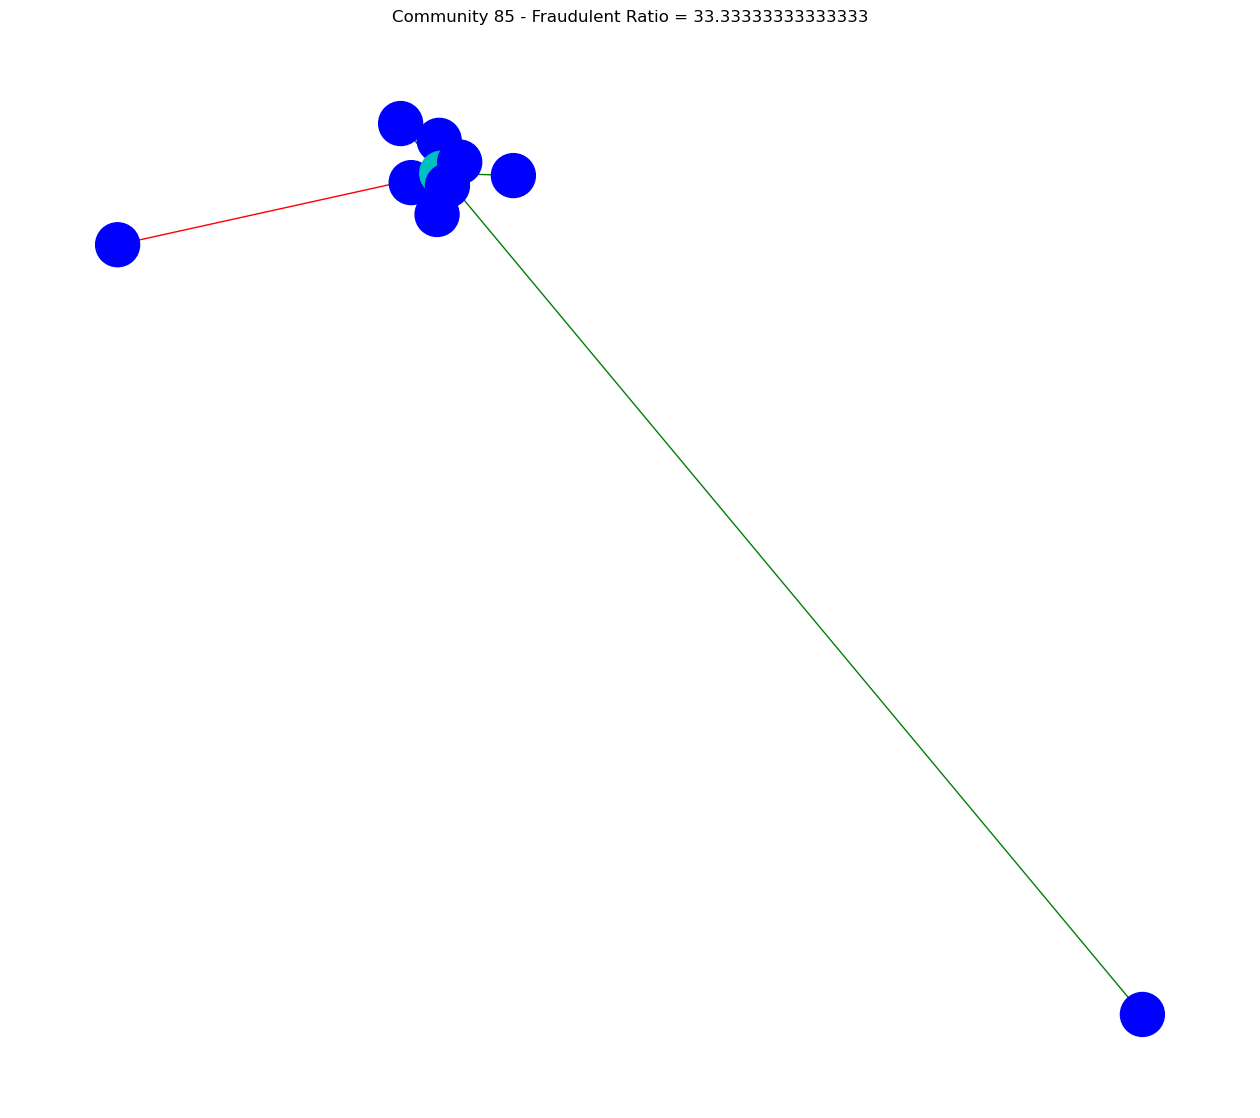

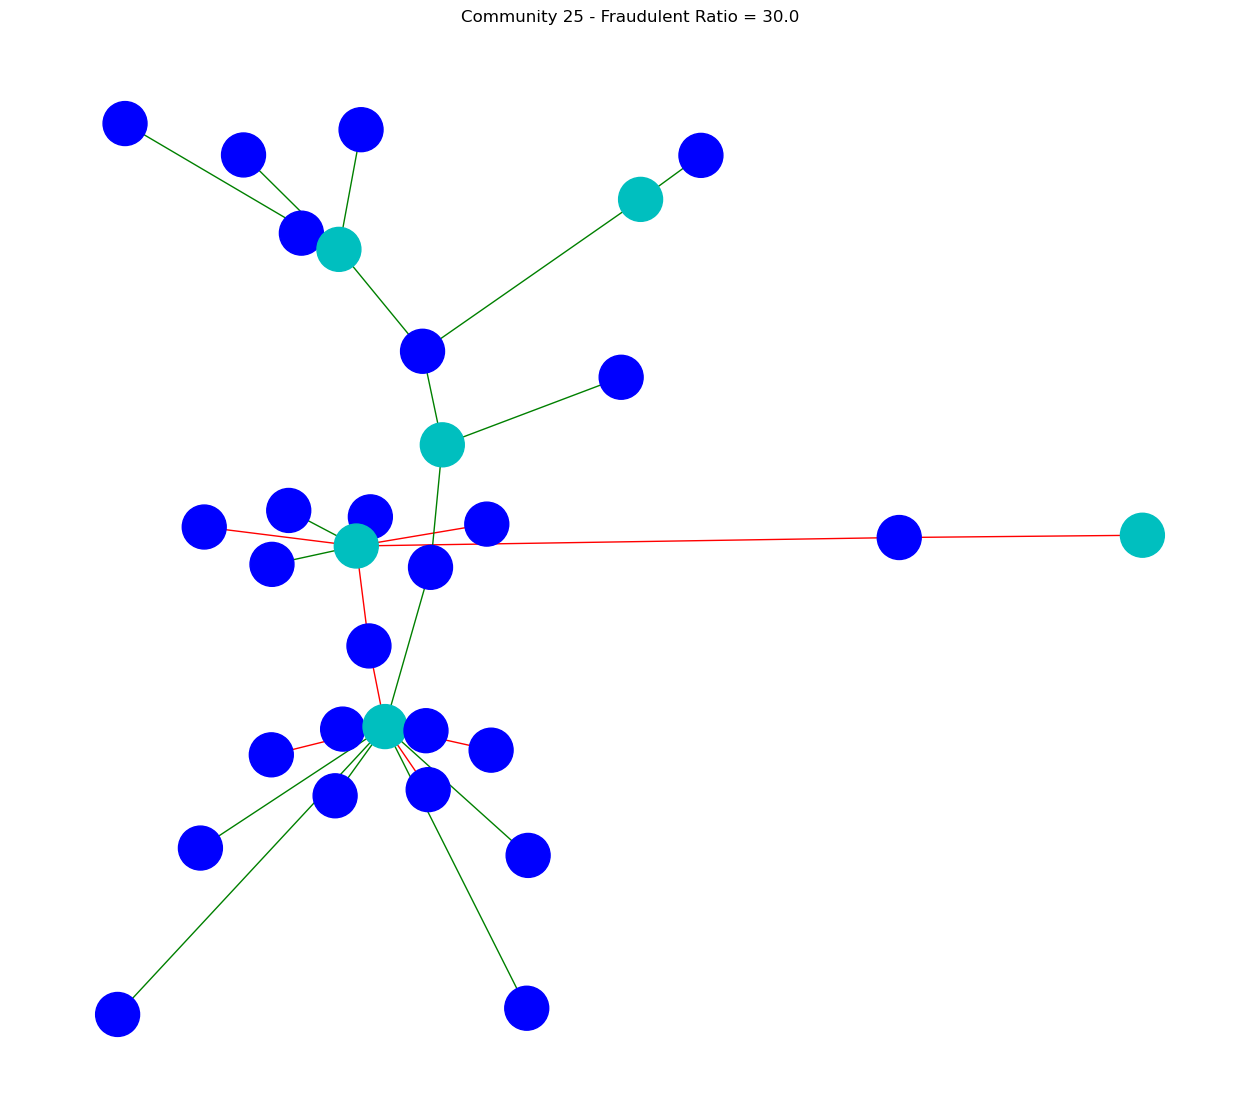

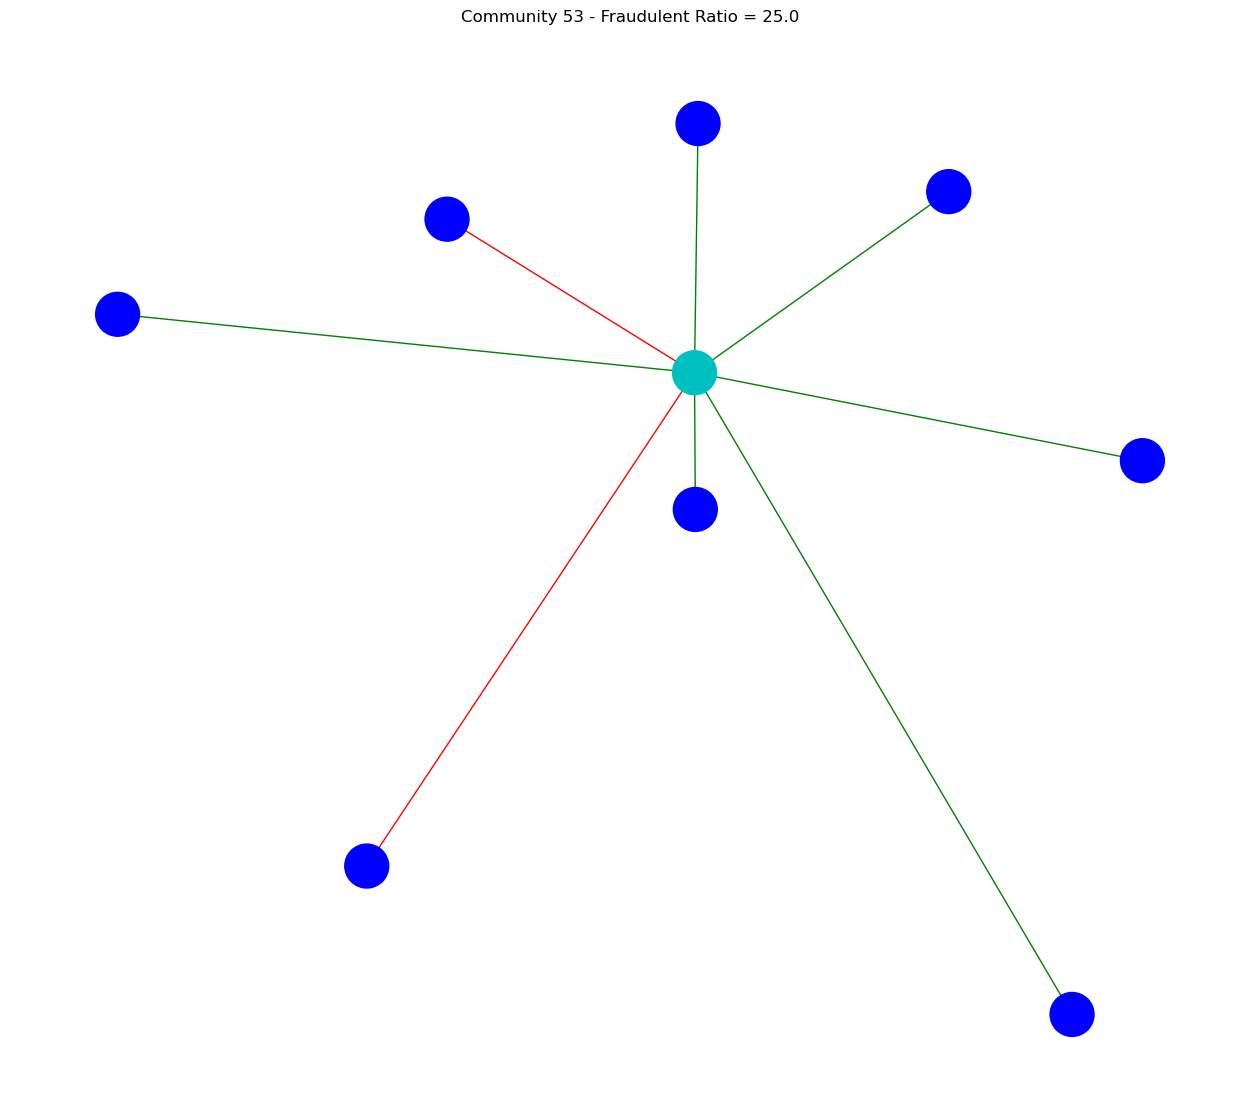

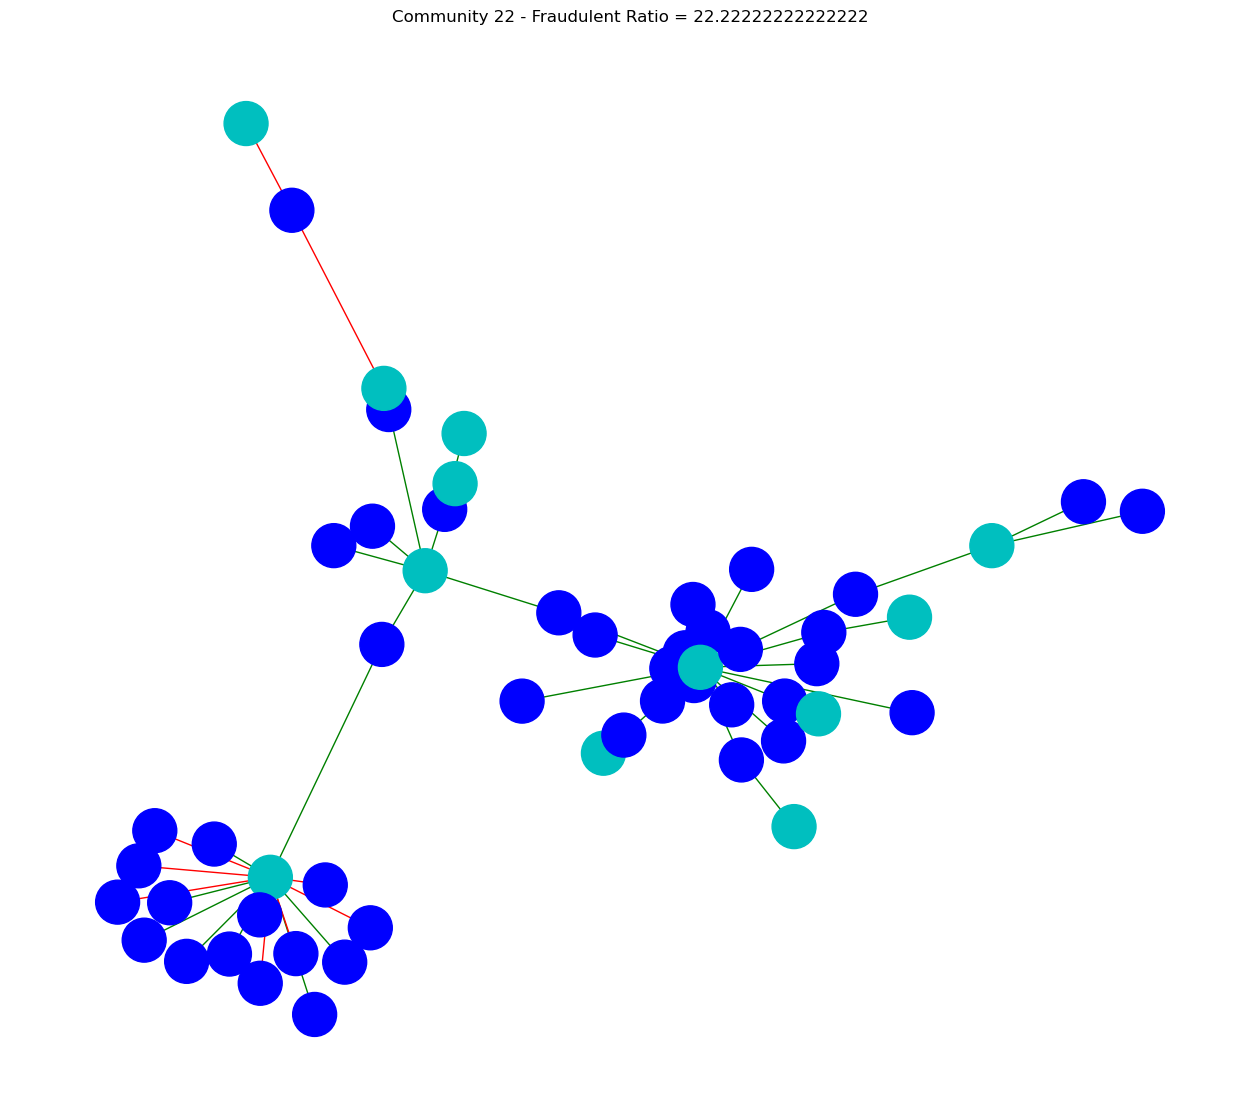

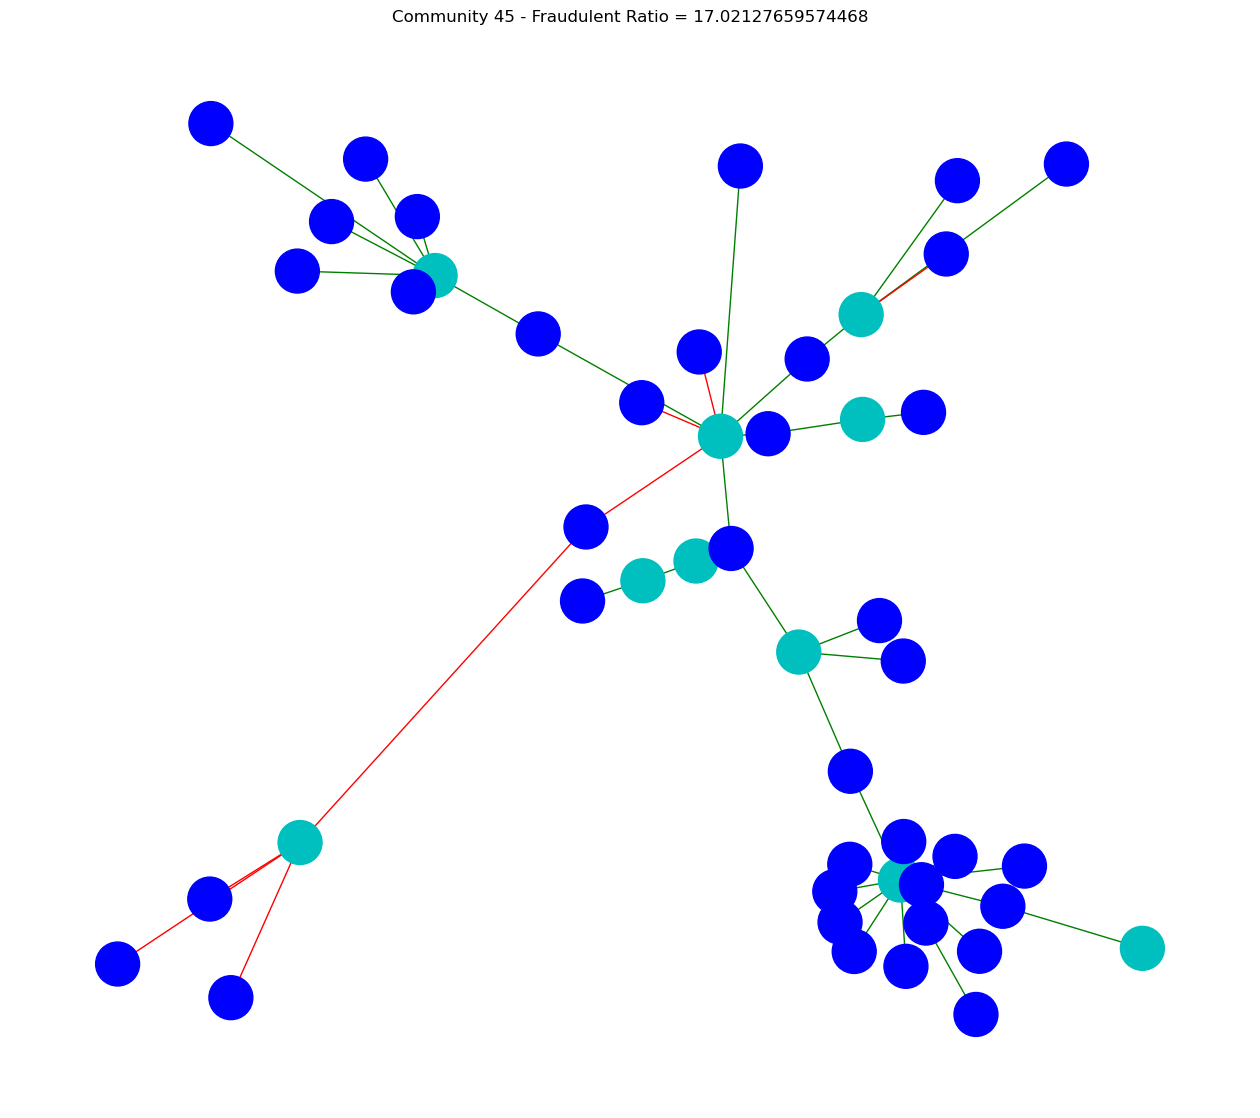

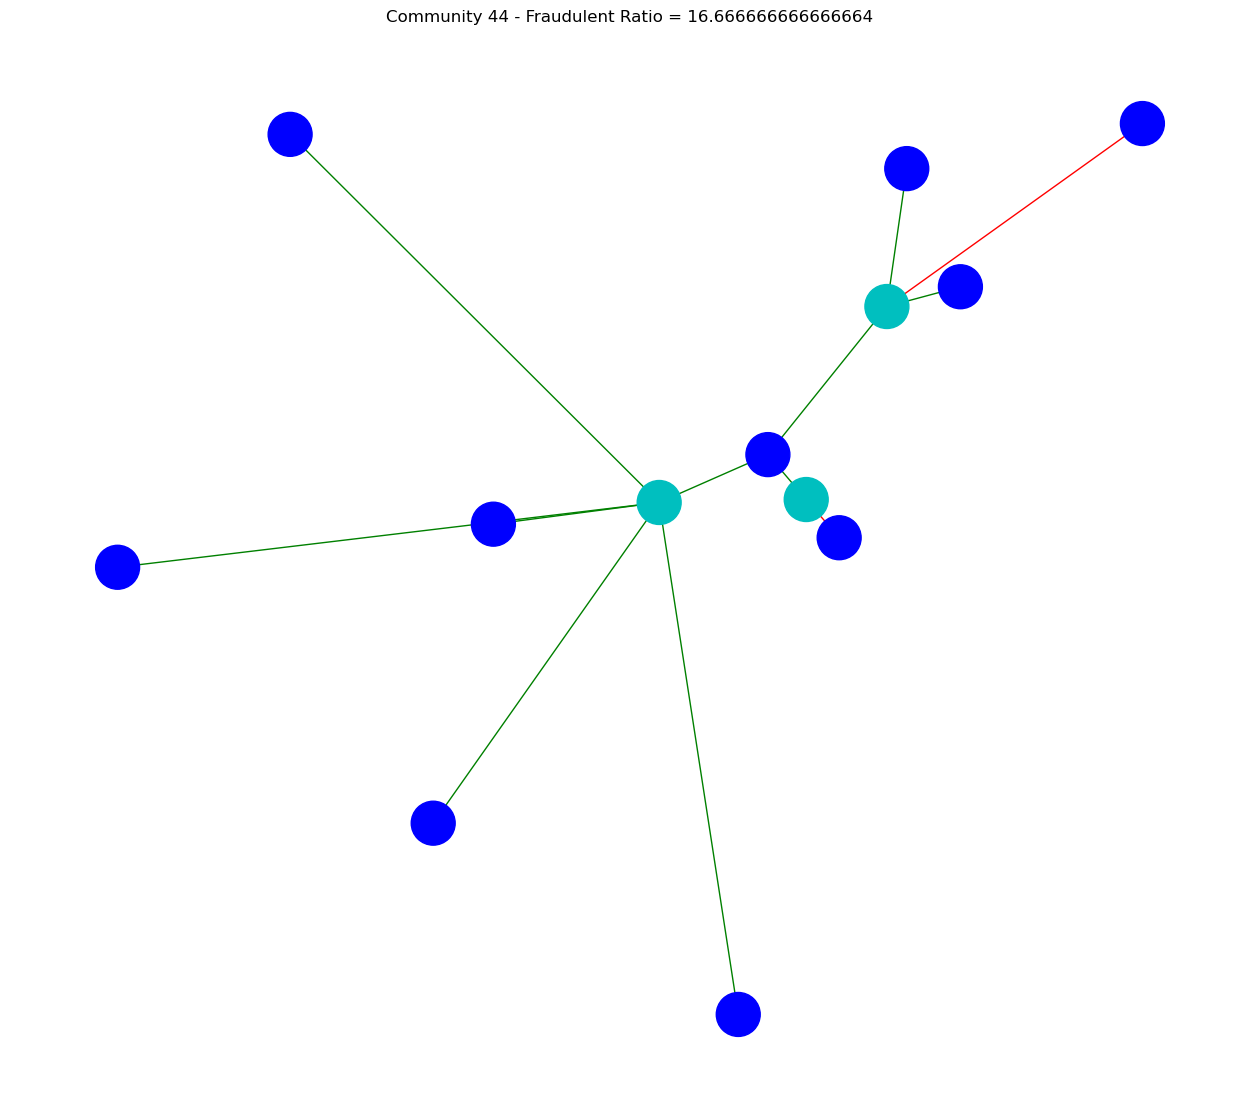

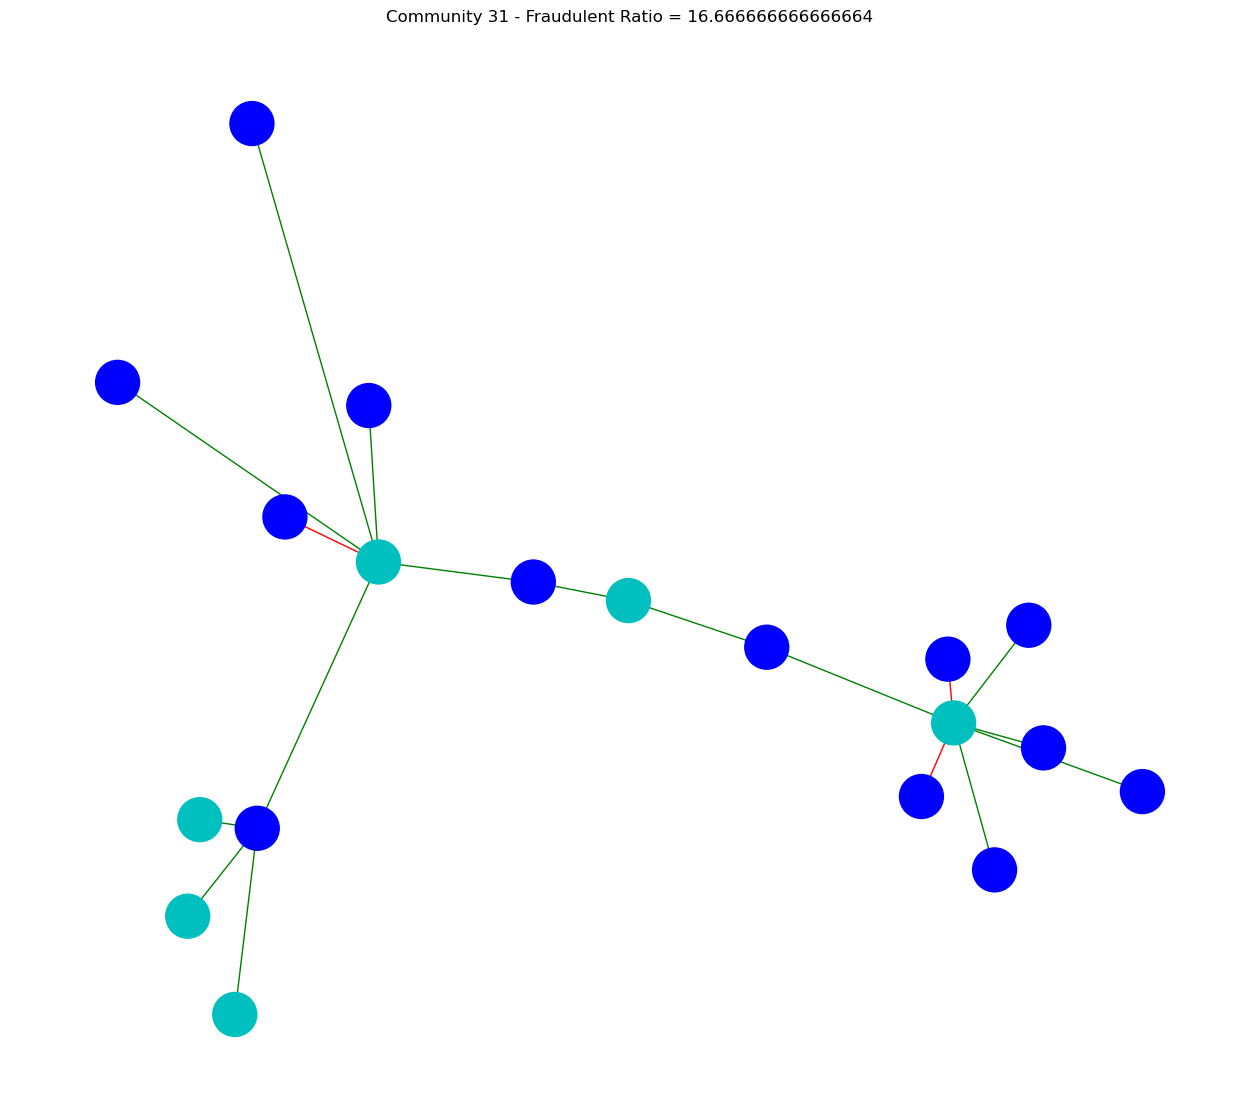

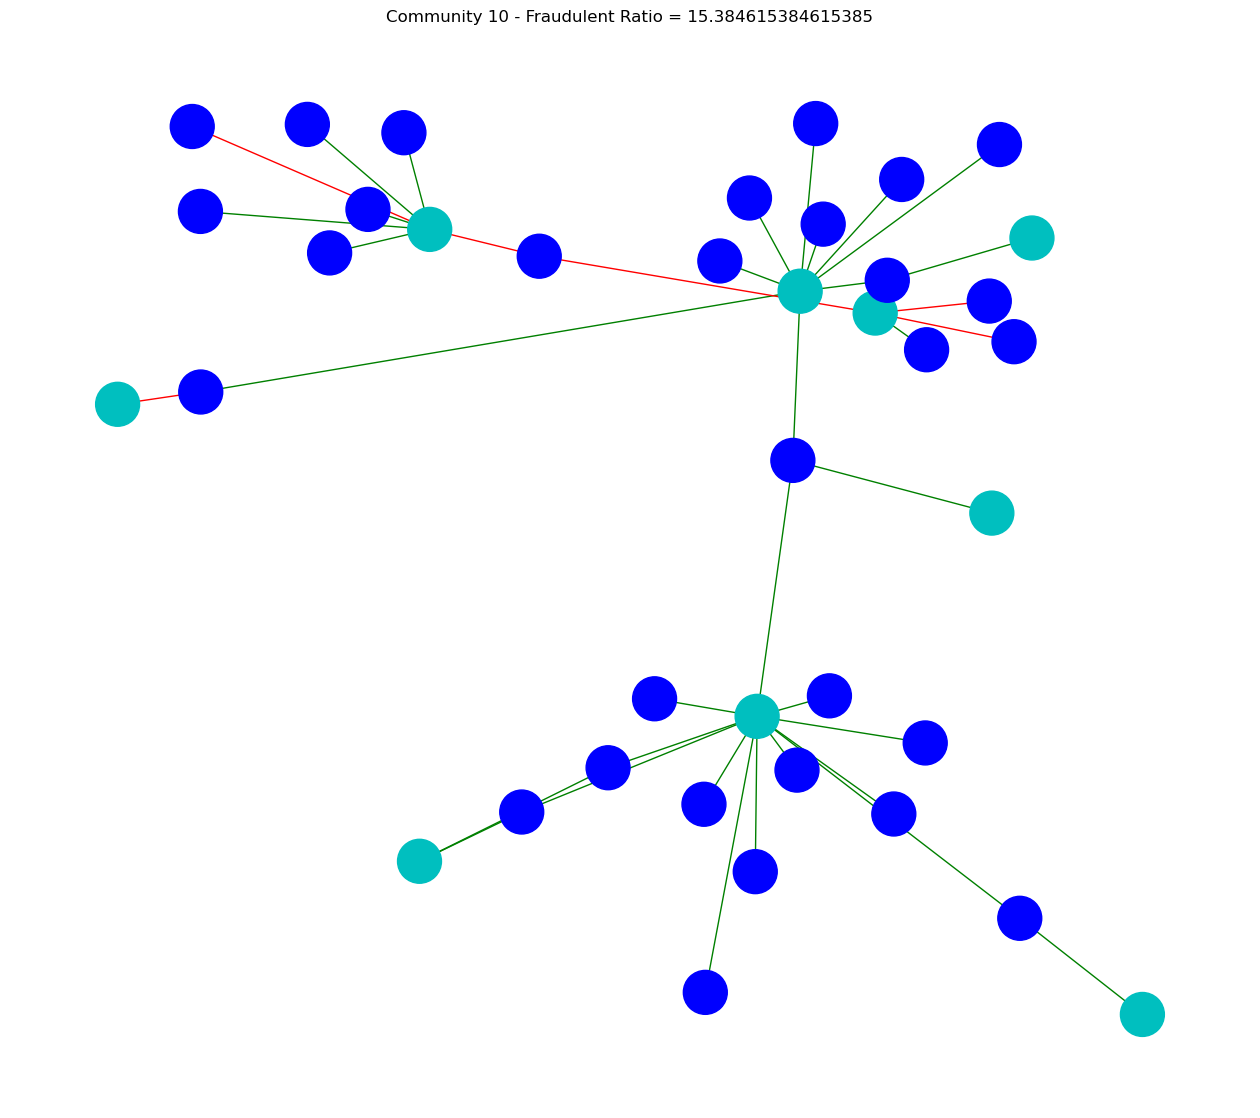

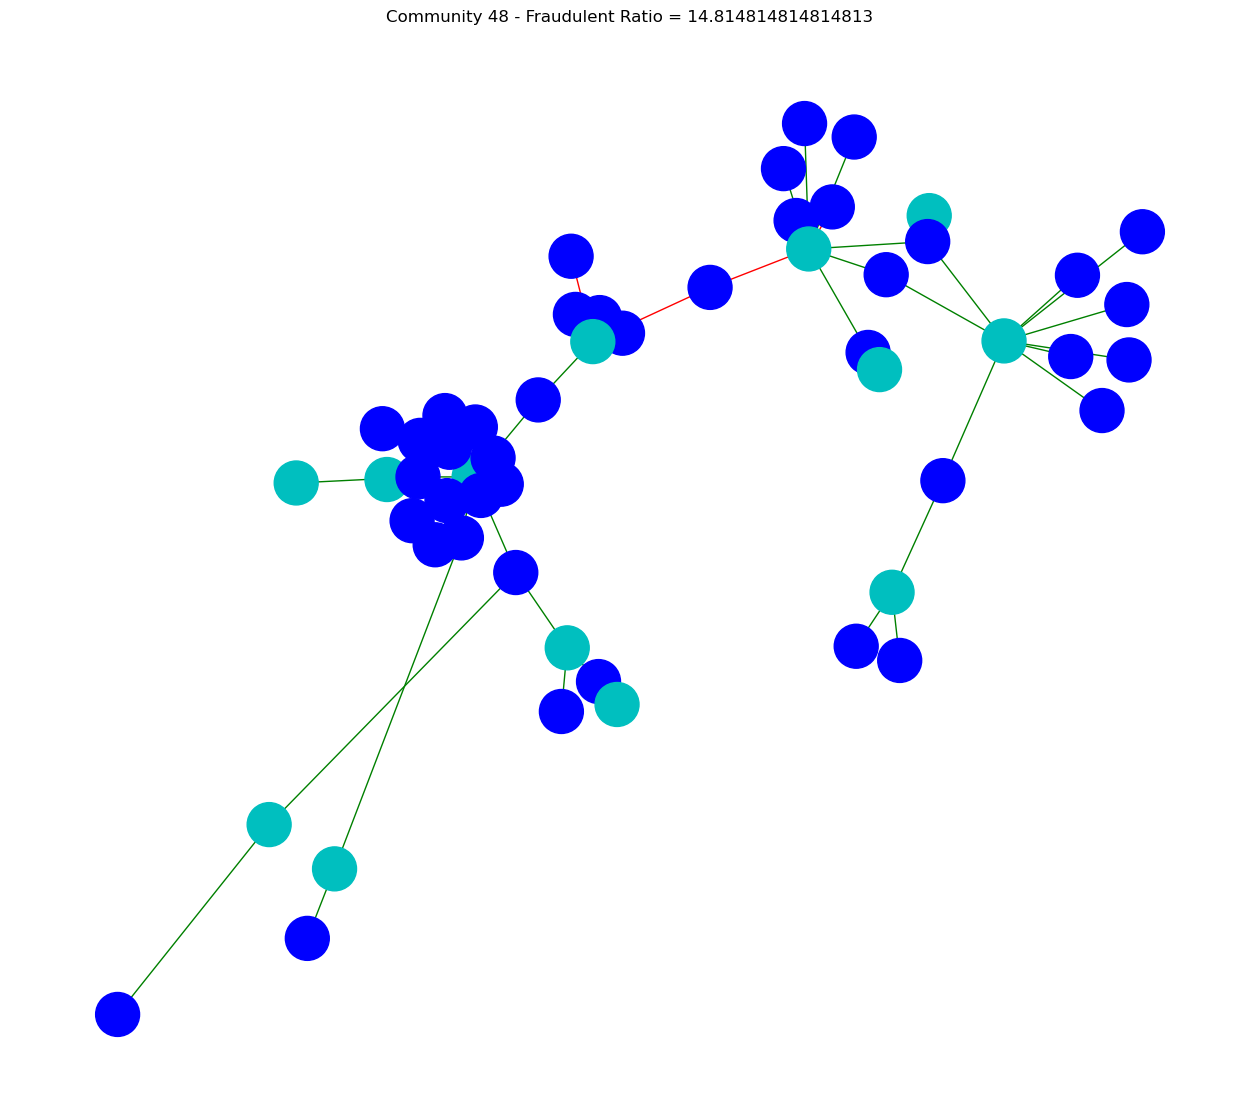

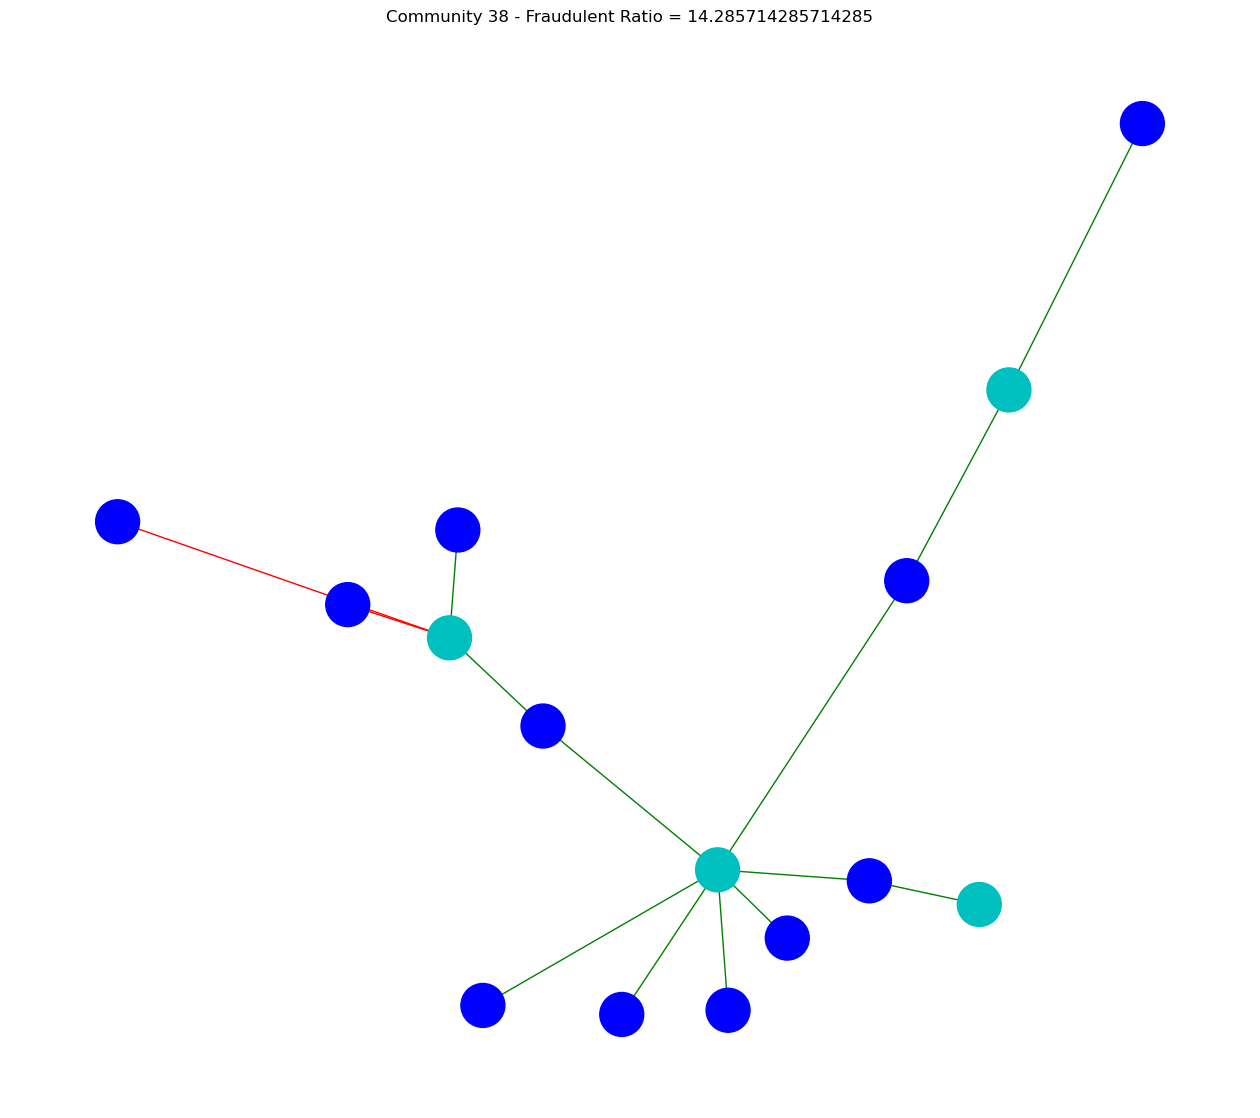

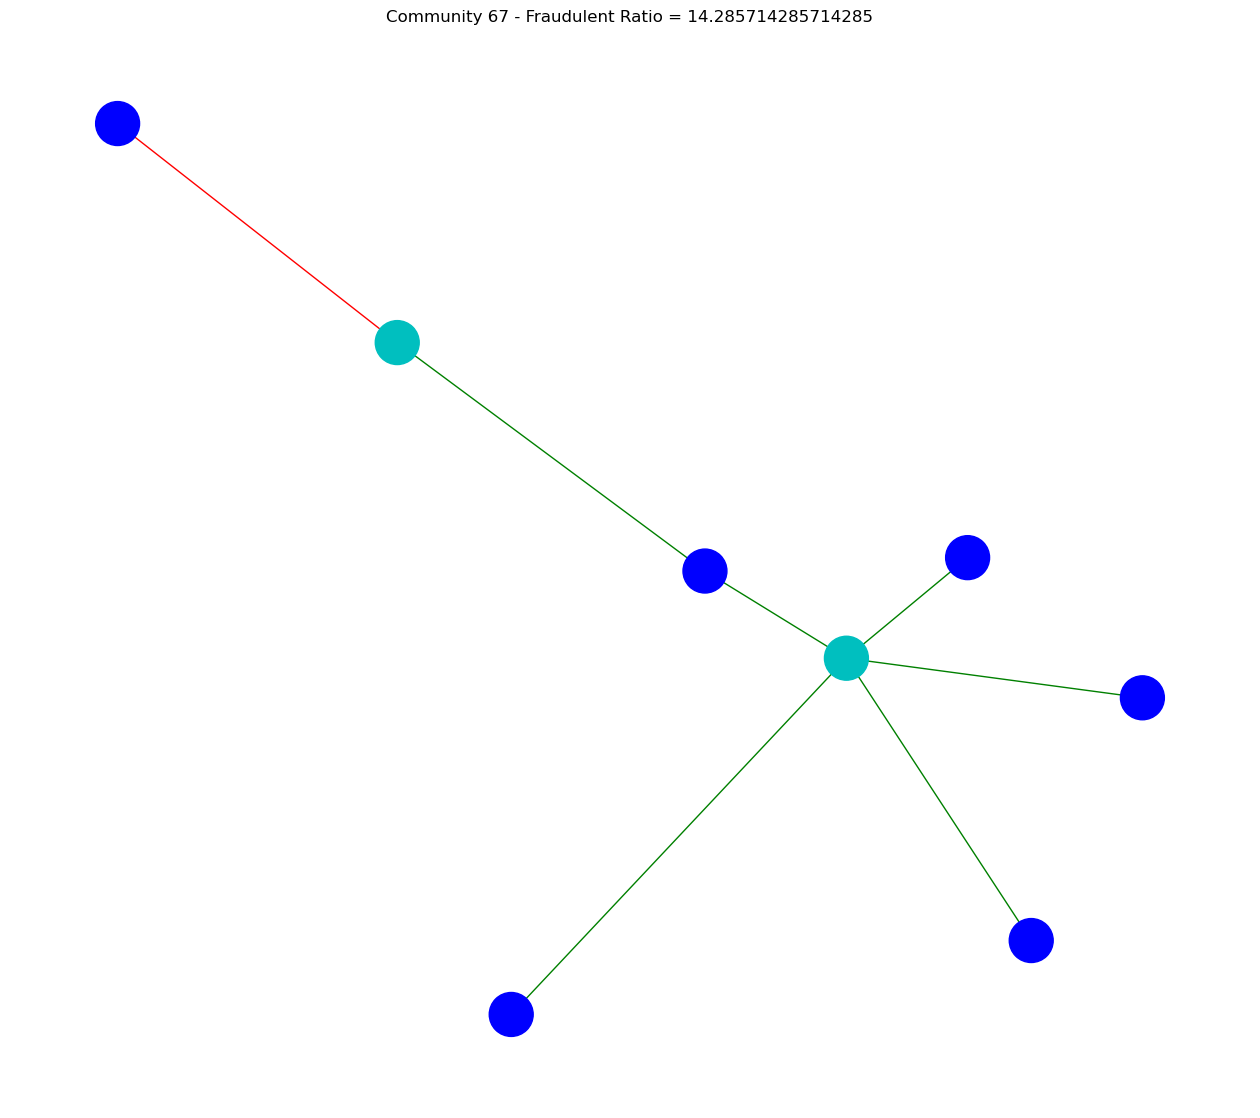

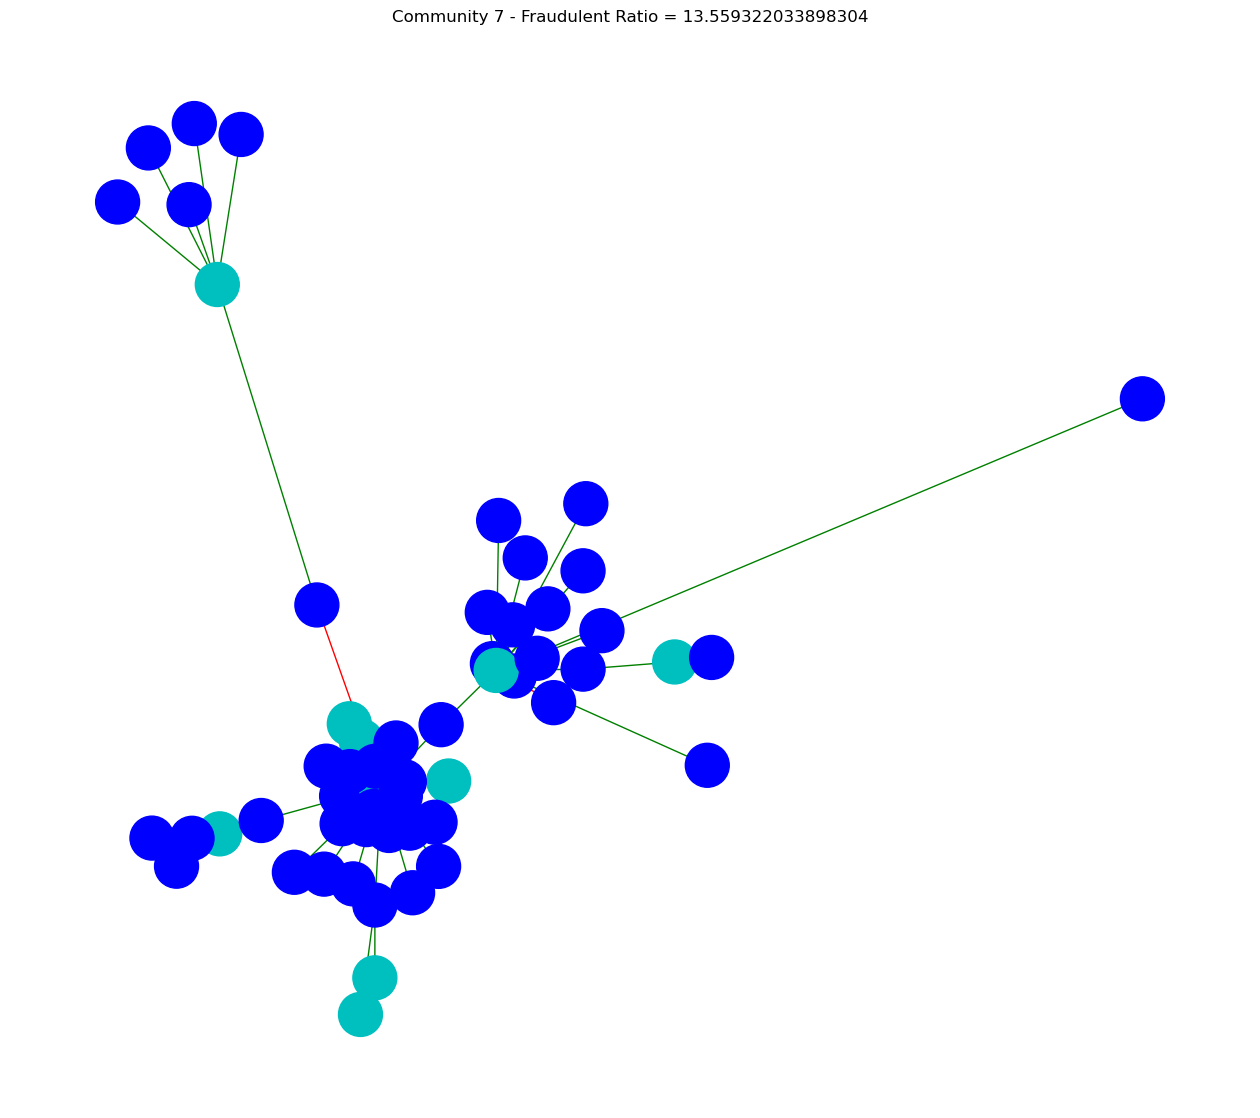

In [391]:
# Print Top 30 communities with the highest fraud / benign ratio
for gId in pd.Series(bi_ratios).sort_values(ascending=False).index[20:40]:
    plot_community(bi_graphs, bi_ratios, bi_mapping, gId)

In [306]:
str(df_downsampled.loc[55824]["Transaction Date and Time"])

'2023-02-21 01:59:40'

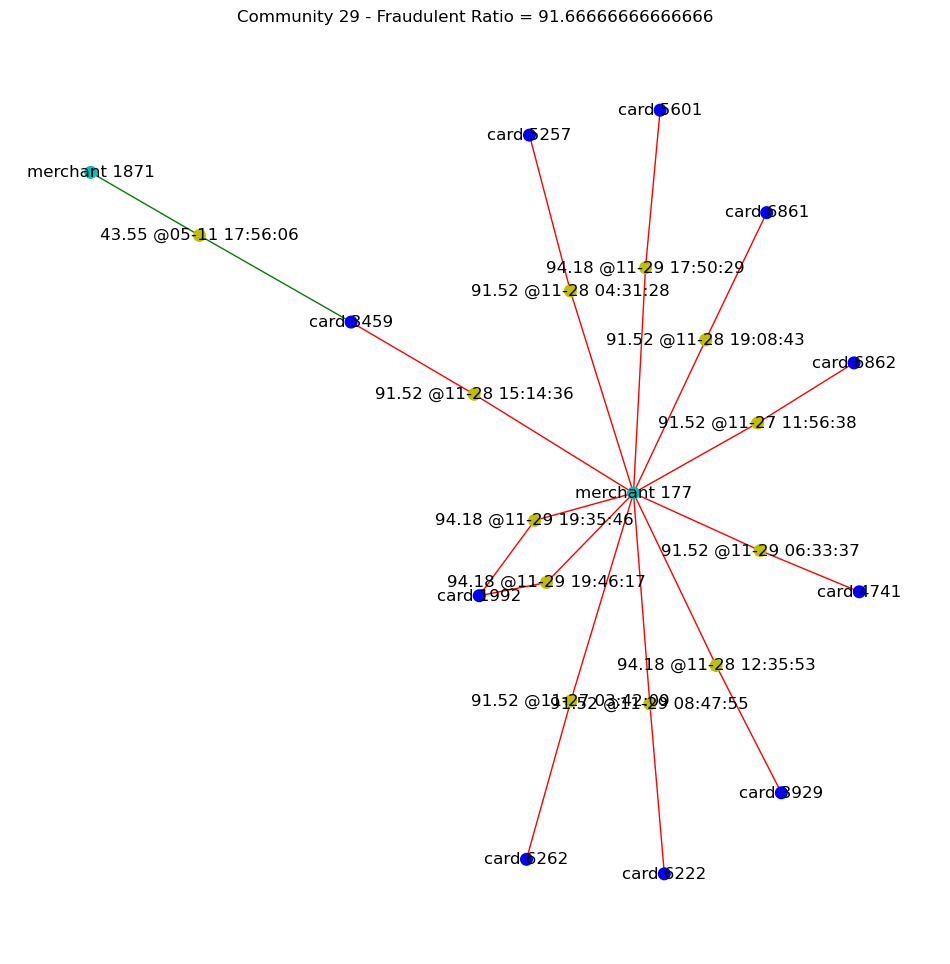

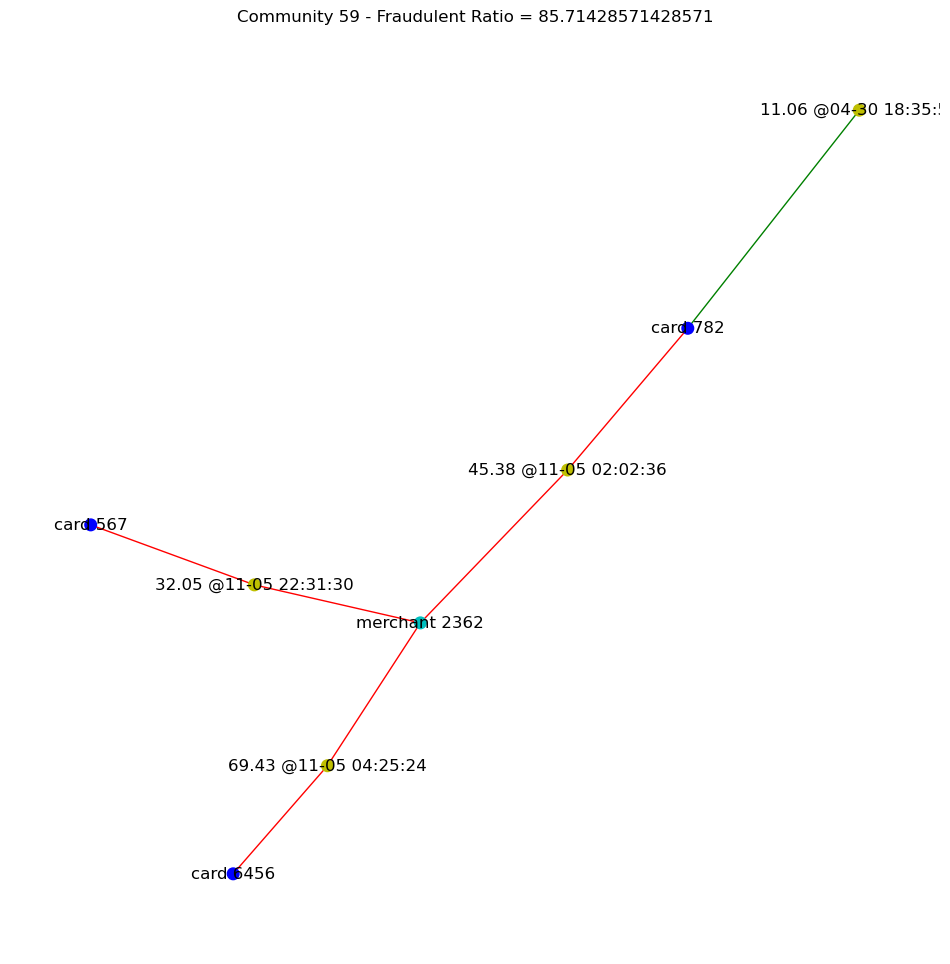

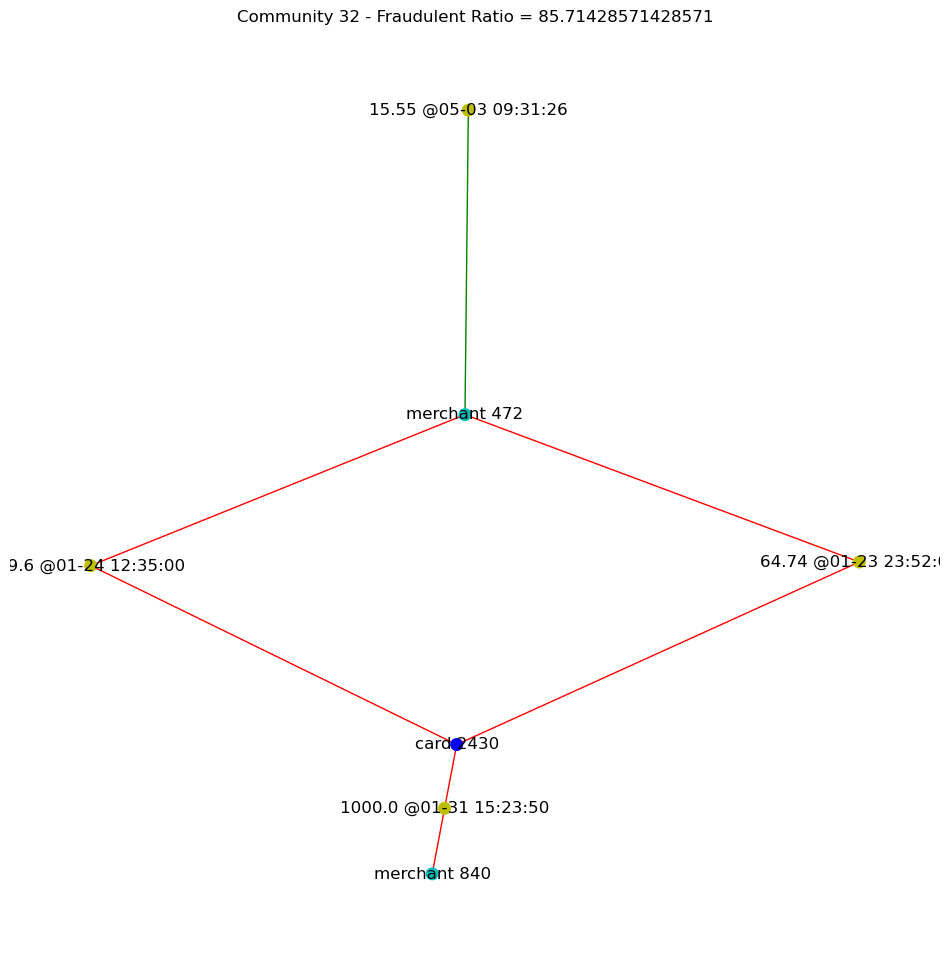

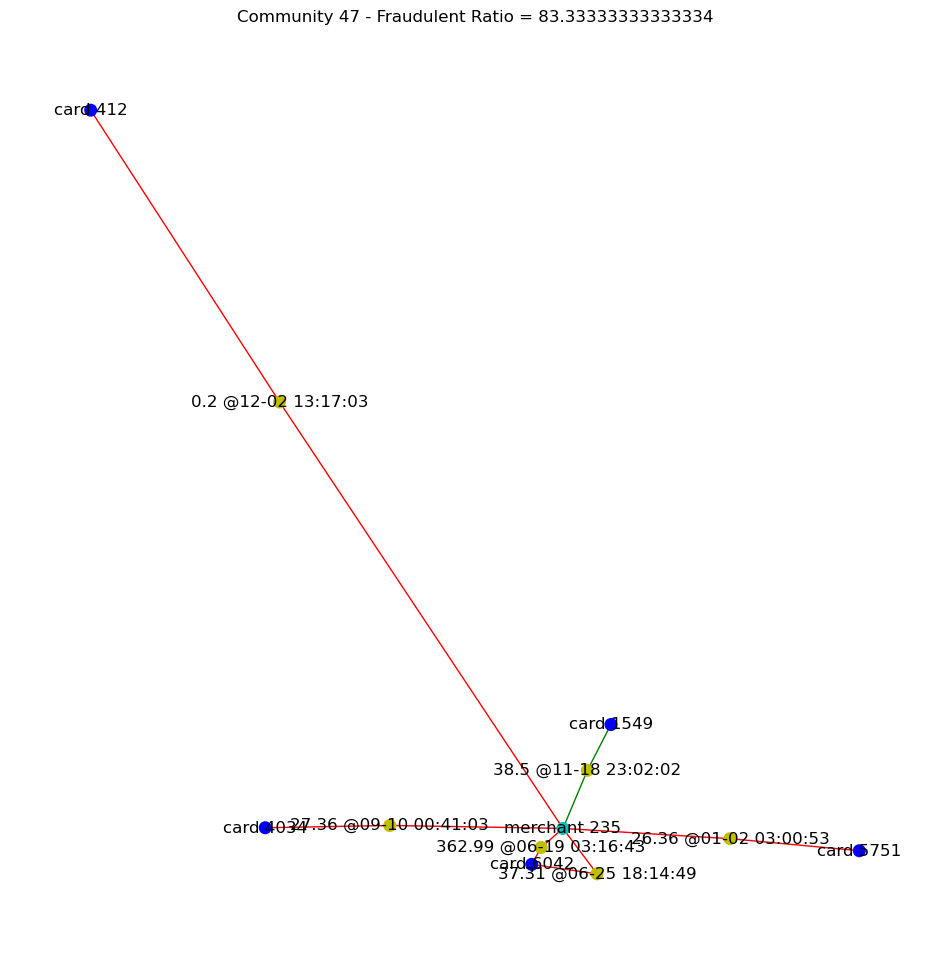

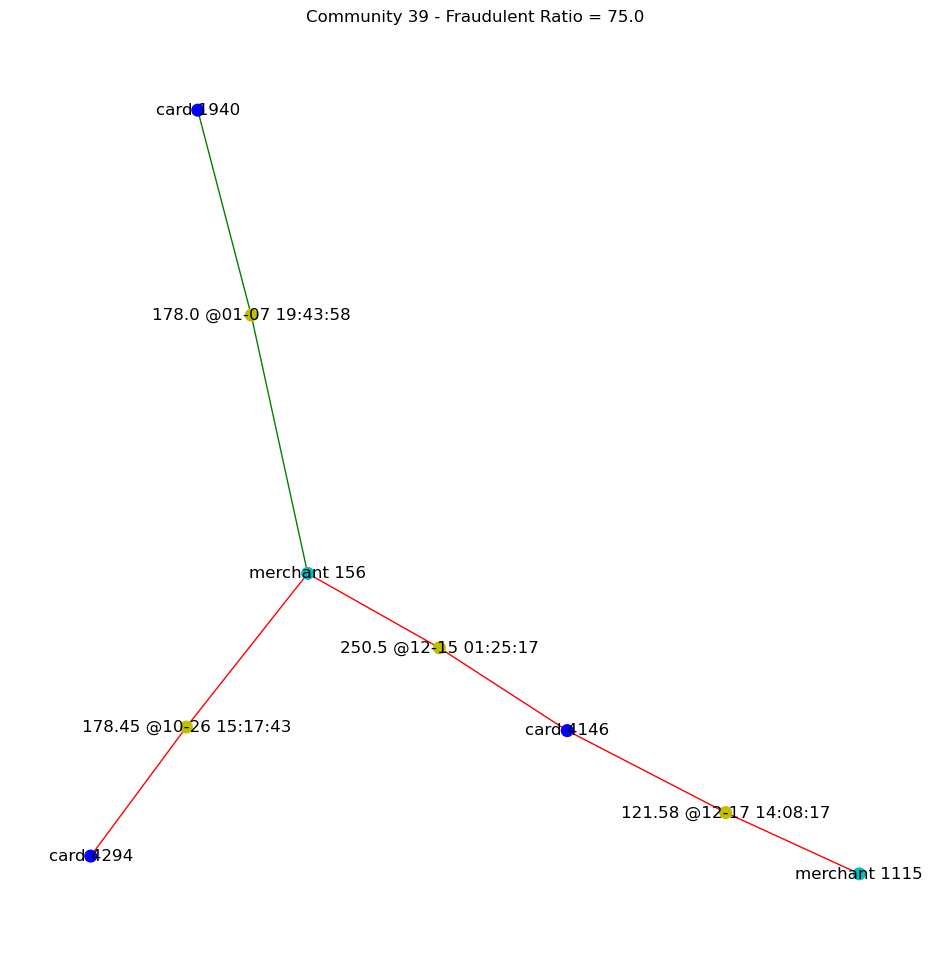

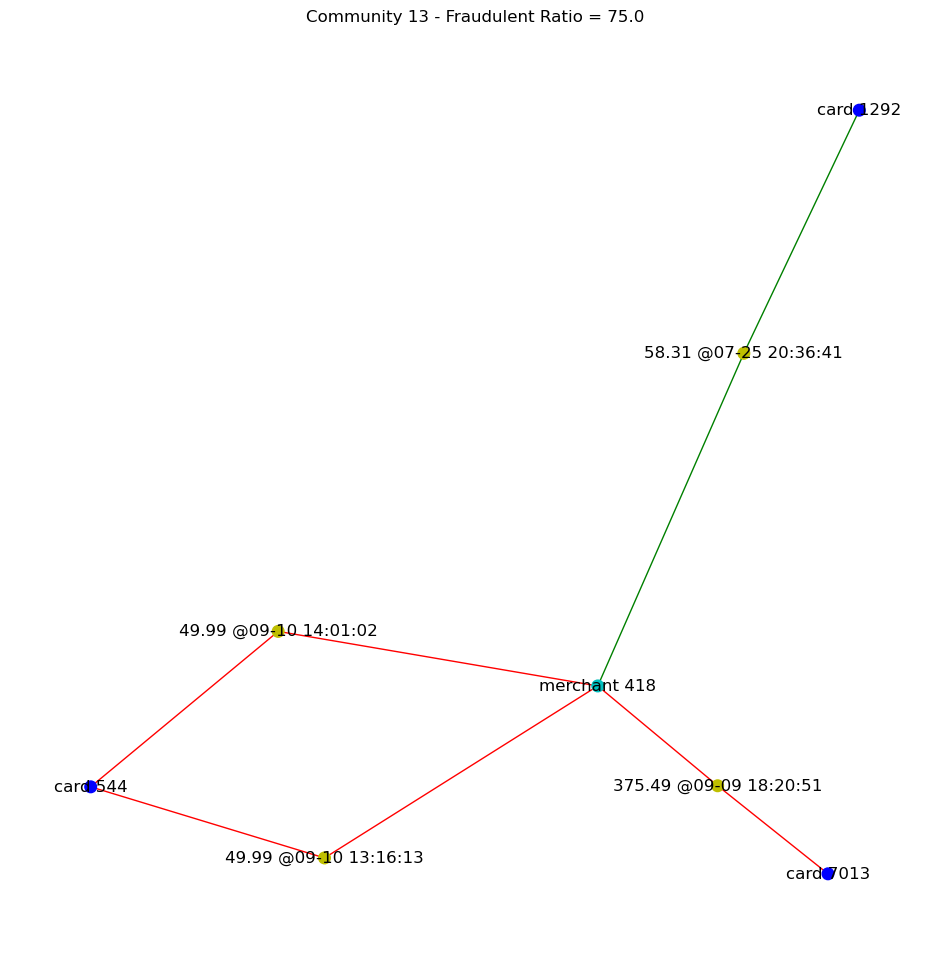

In [315]:
# Print Top 30 communities with the highest fraud / benign ratio
for gId in pd.Series(tri_ratios).sort_values(ascending=False).index[19:25]:
    plot_community(tri_graphs, tri_ratios, tri_mapping, gId)

In [380]:
x = df_downsampled[df_downsampled['Merchant Identifier'] == "merchant 177"]
x

Card Identifier Transaction Date Transaction Time  Risk Assessment  \
23691       card 1992       2023-11-29         19:46:17           3832.0   
37903       card 3459       2023-11-28         15:14:36           2782.0   
44565       card 5257       2023-11-28         04:31:28           3812.0   
53456       card 6222       2023-11-29         08:47:55           2832.0   
54554       card 6262       2023-11-27         03:42:09           3777.0   
62636       card 4741       2023-11-29         06:33:37           3902.0   
66638       card 3929       2023-11-28         12:35:53           2457.0   
69887       card 6861       2023-11-28         19:08:43           2977.0   
69968       card 6862       2023-11-27         11:56:38           1982.0   
77079       card 1992       2023-11-29         19:35:46           2497.0   
98824       card 5601       2023-11-29         17:50:29           2847.0   

      Payment Method  Transaction Value Merchant Location Card Present Status  \
23691         Online              94.18               SGP                 CNP   
37903         Online              91.52               SGP                 CNP   
44565         Online              91.52               SGP                 CNP   
53456         Online              91.52               SGP                 CNP   
54554         Online              91.52               SGP                 CNP   
62636         Online              91.52               SGP                 CNP   
66638         Online              94.18               SGP                 CNP   
69887         Online              91.52               SGP                 CNP   
69968         Online              91.52               SGP                 CNP   
77079         Online              94.18               SGP                 CNP   
98824         Online              94.18               SGP                 CNP   

      Chip Usage Cross-border Transaction (Yes/No) Acquiring Institution ID  \
23691         No                               Yes             acquirer 128   
37903         No                               Yes             acquirer 128   
44565         No                               Yes             acquirer 134   
53456         No                               Yes             acquirer 134   
54554         No                               Yes             acquirer 134   
62636         No                               Yes             acquirer 134   
66638         No                               Yes             acquirer 128   
69887         No                               Yes             acquirer 134   
69968         No                               Yes             acquirer 128   
77079         No                               Yes             acquirer 128   
98824         No                               Yes             acquirer 128   

      Merchant Identifier  Merchant Category Code (MCC)  \
23691        merchant 177                        7311.0   
37903        merchant 177                        7311.0   
44565        merchant 177                        7311.0   
53456        merchant 177                        7311.0   
54554        merchant 177                        7311.0   
62636        merchant 177                        7311.0   
66638        merchant 177                        7311.0   
69887        merchant 177                        7311.0   
69968        merchant 177                        7311.0   
77079        merchant 177                        7311.0   
98824        merchant 177                        7311.0   

      Fraud Indicator (Yes/No) Transaction Date and Time  Fraud Indicator  
23691                      Yes       2023-11-29 19:46:17                1  
37903                      Yes       2023-11-28 15:14:36                1  
44565                      Yes       2023-11-28 04:31:28                1  
53456                      Yes       2023-11-29 08:47:55                1  
54554                      Yes       2023-11-27 03:42:09                1  
62636 

In [ ]:
df

In [384]:
x.shape

(11, 16)

In [382]:
x['Card Identifier'].unique()

array(['card 1992', 'card 3459', 'card 5257', 'card 6222', 'card 6262',
       'card 4741', 'card 3929', 'card 6861', 'card 6862', 'card 5601'],
      dtype=object)

In [383]:
x['Transaction Value'].unique()

array([94.18, 91.52])

In [385]:
sum(x['Transaction Value'])

1017.3600000000001

In [387]:
df[df['Merchant Identifier'] == "merchant 177"]

Card Identifier Transaction Date Transaction Time  Risk Assessment  \
436          card 383       2023-11-27         09:07:27           2277.0   
15608       card 4116       2023-11-29         21:30:49           2992.0   
23691       card 1992       2023-11-29         19:46:17           3832.0   
25113        card 883       2023-11-29         17:03:35           3877.0   
34856       card 2657       2023-11-28         21:25:27           2017.0   
37903       card 3459       2023-11-28         15:14:36           2782.0   
44565       card 5257       2023-11-28         04:31:28           3812.0   
51125       card 6468       2023-11-29         16:45:20           3767.0   
53456       card 6222       2023-11-29         08:47:55           2832.0   
54554       card 6262       2023-11-27         03:42:09           3777.0   
60453       card 5455       2023-11-29         09:55:18           2577.0   
62636       card 4741       2023-11-29         06:33:37           3902.0   
66638       card 3929       2023-11-28         12:35:53           2457.0   
67621       card 1118       2023-11-28         05:47:07           3017.0   
69887       card 6861       2023-11-28         19:08:43           2977.0   
69968       card 6862       2023-11-27         11:56:38           1982.0   
77079       card 1992       2023-11-29         19:35:46           2497.0   
91055       card 6913       2023-11-29         15:04:14           2942.0   
97609       card 3679       2023-11-28         11:56:57           2867.0   
98824       card 5601       2023-11-29         17:50:29           2847.0   

      Payment Method  Transaction Value Merchant Location Card Present Status  \
436           Online              91.30               SGP                 CNP   
15608         Online              94.18               SGP                 CNP   
23691         Online              94.18               SGP                 CNP   
25113         Online              94.18               SGP                 CNP   
34856         Online              91.52               SGP                 CNP   
37903         Online              91.52               SGP                 CNP   
44565         Online              91.52               SGP                 CNP   
51125         Online              94.18               HKG                 CNP   
53456         Online              91.52               SGP                 CNP   
54554         Online              91.52               SGP                 CNP   
60453         Online              94.18               SGP                 CNP   
62636         Online              91.52               SGP                 CNP   
66638         Online              94.18               SGP                 CNP   
67621         Online              94.18               SGP                 CNP   
69887         Online              91.52               SGP                 CNP   
69968         Online              91.52               SGP                 CNP   
77079         Online              94.18               SGP                 CNP   
91055         Online              94.18               SGP                 CNP   
97609         Online              94.18               SGP                 CNP   
98824         Online              94.18               SGP                 CNP   

      Chip Usage Cross-border Transaction (Yes/No) Acquiring Institution ID  \
436           No                               Yes             acquirer 134   
15608         No                               Yes             acquirer 128   
23691         No                               Yes             acquirer 128   
25113         No                               Yes             acquirer 128   
34856         No                               Yes             acquirer 128   
37903         No                               Yes             acquirer 128   
44565         No                               Yes             acquirer 134   
51125         No                               Yes             acquirer 807

## Model Building

In [219]:
df_maj_downsampled['Transaction Value'] = 10

In [321]:
fraud['Risk Assessment'].isnull().sum()

0

In [319]:
df[df['Risk Assessment'] == 0]

Empty DataFrame
Columns: [Card Identifier, Transaction Date, Transaction Time, Risk Assessment, Payment Method, Transaction Value, Merchant Location, Card Present Status, Chip Usage, Cross-border Transaction (Yes/No), Acquiring Institution ID, Merchant Identifier, Merchant Category Code (MCC), Fraud Indicator (Yes/No), Transaction Date and Time, Fraud Indicator]
Index: []

In [322]:
from sklearn.utils import resample

# train_df = df[['Card Identifier', 'Transaction Value', 'Merchant Identifier', 'Fraud Indicator']]
train_df = df[df['Transaction Value'] != 0]
train_df = train_df.dropna(subset=["Risk Assessment"])
# train_df['Transaction Value'] = train_df['Transaction Value'].astype(int, errors="raise")
# train_df['Transaction Value'] = train_df['Transaction Value'].apply(lambda x: int(x) if not pd.isnull(x) else x)

df_majority = train_df[train_df['Fraud Indicator'] == 0]
df_minority = train_df[train_df['Fraud Indicator'] == 1]


# df_maj_downsampled = resample(df_majority, n_samples=200, random_state=21)
df_maj_downsampled = df_majority.sample(n=len(df_minority), random_state=42)
# df_maj_downsampled['Transaction Value'] = 3
df_downsampled = pd.concat([df_minority, df_maj_downsampled])
# df_downsampled = df_downsampled.dropna()
# df_maj_downsampled = df_maj_downsampled.dropna()

In [325]:
df_downsampled["Fraud Indicator"].value_counts()

Fraud Indicator
1    265
0    265
Name: count, dtype: int64

In [332]:
def build_graph_bipartite(df_input, graph_type=nx.Graph()):
    df = df_input.copy()
    mapping = {x:node_id for node_id, x in enumerate(set(df["Card Identifier"].values.tolist() + df["Merchant Identifier"].values.tolist()))}
    
    df["from"] = df["Card Identifier"].apply(lambda x: mapping[x])
    df["to"] = df["Merchant Identifier"].apply(lambda x: mapping[x])
    
    df = df[["from", "to", "Transaction Value", "Fraud Indicator", "Risk Assessment"]].groupby(['from', 'to']).agg({"Fraud Indicator": sum, "Transaction Value": sum, "Risk Assessment": sum}).reset_index()
    
    df["Fraud Indicator"] = df["Fraud Indicator"].apply(lambda x: 1 if x>0 else 0)

    df["Weight"] = df["Risk Assessment"] * df["Transaction Value"]
    
    G = nx.from_edgelist(df[["from", "to"]].values, create_using=graph_type)
    nx.set_edge_attributes(G, {(int(x["from"]), \
                               int(x["to"])):x["Fraud Indicator"] \
                               for idx, x in \
                               df[["from", "to", "Fraud Indicator"]].iterrows()},
                           "label")
    
    nx.set_edge_attributes(G, {(int(x["from"]), \
                               int(x["to"])):x["Weight"] \
                               for idx, x in \
                               df[["from", "to", "Weight"]].iterrows()},
                           "weight")
    return G, mapping

def build_graph_tripartite(df_input, graph_type=nx.Graph()):
    df = df_input.copy()
    mapping = {x:node_id for node_id,x in enumerate(set(df.index.values.tolist() + 
                                                        df["Card Identifier"].values.tolist() + 
                                                        df["Merchant Identifier"].values.tolist()))}
    df["in_node"] = df["Card Identifier"].apply(lambda x: mapping[x])
    df["out_node"] = df["Merchant Identifier"].apply(lambda x: mapping[x])

    G = nx.from_edgelist([(x["in_node"], mapping[idx]) for idx, x in df.iterrows()] +
                         [(x["out_node"], mapping[idx]) for idx, x in df.iterrows()], 
                         create_using=graph_type)

    nx.set_node_attributes(G,{x["in_node"]:1 for idx,x in df.iterrows()}, "bipartite")
    nx.set_node_attributes(G,{x["out_node"]:2 for idx,x in df.iterrows()}, "bipartite")
    nx.set_node_attributes(G,{mapping[idx]:3 for idx, x in df.iterrows()}, "bipartite")

    nx.set_edge_attributes(G,{(x["in_node"], mapping[idx]):x["Fraud Indicator"] for idx, x in df.iterrows()}, "label")
    nx.set_edge_attributes(G,{(x["out_node"], mapping[idx]):x["Fraud Indicator"] for idx, x in df.iterrows()}, "label")

    nx.set_edge_attributes(G,{(x["in_node"], mapping[idx]):x["Transaction Value"] * x["Risk Assessment"] for idx, x in df.iterrows()}, "weight")
    nx.set_edge_attributes(G,{(x["out_node"], mapping[idx]):x["Transaction Value"] * x["Risk Assessment"] for idx, x in df.iterrows()}, "weight")
    return G, mapping

# Undirected Graph
# G_down, mapping = build_graph_bipartite(df_downsampled, nx.Graph(name="Bipartite Undirect"))
G_down, mapping = build_graph_tripartite(df_downsampled, nx.Graph(name="Tripartite Undirect"))


In [301]:
df = df_downsampled.copy()
# df = df_input.copy()
mapping = {x:node_id for node_id,x in enumerate(set(df.index.values.tolist() + 
                                                    df["Card Identifier"].values.tolist() + 
                                                    df["Merchant Identifier"].values.tolist()))}
df["in_node"] = df["Card Identifier"].apply(lambda x: mapping[x])
df["out_node"] = df["Merchant Identifier"].apply(lambda x: mapping[x])


In [302]:
df

Card Identifier  Transaction Value Merchant Identifier  Fraud Indicator  \
41           card 867              25.42        merchant 126                1   
283         card 1596              97.68          merchant 8                1   
1126         card 606              24.96          merchant 1                1   
1536        card 2407             109.05          merchant 1                1   
2185        card 2570             117.98        merchant 816                1   
...               ...                ...                 ...              ...   
64332       card 6288               6.39         merchant 82                0   
56104        card 694               1.00        merchant 207                0   
6862         card 544              11.47         merchant 84                0   
86942       card 2793             125.80          merchant 1                0   
24730       card 1361               3.45         merchant 77                0   

       in_node  out_node  
41         509       230  
283        274       799  
1126       138        26  
1536       599        26  
2185       351       759  
...        ...       ...  
64332      582       372  
56104      838       154  
6862       367       760  
86942      835        26  
24730      235       606  

[530 rows x 6 columns]

In [333]:
from sklearn.model_selection import train_test_split

train_edges, test_edges, train_labels, test_labels = train_test_split(list(range(len(G_down.edges))),
                                                                      list(nx.get_edge_attributes(G_down, "label").values()),
                                                                      test_size=0.2,
                                                                      random_state=42)

edgs = list(G_down.edges)
train_graph = G_down.edge_subgraph([edgs[x] for x in train_edges]).copy()
train_graph.add_nodes_from(list(set(G_down.nodes) - set(train_graph.nodes)))

from node2vec import Node2Vec
from node2vec.edges import HadamardEmbedder, AverageEmbedder, WeightedL1Embedder, WeightedL2Embedder

node2vec_train = Node2Vec(train_graph, weight_key='weight')
model_train = node2vec_train.fit(window=10)

Computing transition probabilities:   0%|          | 0/1145 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:03<00:00,  2.82it/s]


In [267]:
# Step 2: Extract node embeddings
# Get a dictionary where keys are nodes and values are their embeddings
node_embeddings = {node: model_train.wv[node] for node in G_down.nodes}

In [284]:
len(node_embeddings[1])

128

In [272]:
len(node_embeddings)

618

In [273]:
df_downsampled['Card Identifier'].nunique()

412

In [274]:
df_downsampled['Merchant Identifier'].nunique()

206

In [280]:
mapping
reversed_mapping = {v:k for k,v in mapping.items()}

In [269]:
dftest = df_downsampled.copy()

for dim in range(model_train.vector_size):
    dim_name = f"embedding_dim_{dim}"
    dftest[dim_name] = dftest.index.apply(lambda x: node_embeddings[x][dim])

AttributeError: 'Index' object has no attribute 'apply'

In [263]:
train_edges

[412,
 25,
 220,
 396,
 231,
 324,
 42,
 414,
 294,
 375,
 325,
 271,
 408,
 394,
 154,
 426,
 22,
 317,
 46,
 31,
 113,
 272,
 311,
 395,
 397,
 57,
 286,
 132,
 406,
 24,
 17,
 403,
 66,
 424,
 420,
 94,
 173,
 225,
 23,
 249,
 450,
 245,
 5,
 116,
 45,
 16,
 447,
 346,
 3,
 203,
 310,
 60,
 110,
 404,
 405,
 29,
 172,
 155,
 26,
 7,
 440,
 108,
 37,
 157,
 451,
 118,
 114,
 441,
 314,
 144,
 358,
 368,
 182,
 253,
 262,
 432,
 141,
 354,
 67,
 208,
 168,
 364,
 237,
 304,
 109,
 449,
 145,
 248,
 152,
 204,
 351,
 83,
 229,
 165,
 244,
 347,
 74,
 299,
 199,
 234,
 119,
 429,
 290,
 342,
 370,
 210,
 331,
 422,
 371,
 265,
 36,
 196,
 139,
 353,
 228,
 454,
 277,
 59,
 111,
 318,
 255,
 6,
 349,
 335,
 158,
 150,
 177,
 382,
 184,
 274,
 10,
 369,
 103,
 81,
 38,
 305,
 167,
 453,
 287,
 284,
 198,
 439,
 416,
 437,
 194,
 89,
 146,
 163,
 381,
 147,
 2,
 92,
 388,
 69,
 278,
 123,
 357,
 96,
 143,
 239,
 423,
 97,
 419,
 122,
 183,
 202,
 246,
 296,
 289,
 340,
 291,
 384,
 275,
 1

In [260]:
len(train_embeddings)

387

In [262]:
len(test_labels)

97

In [290]:
train_embeddings

[array([9.30225197e-03, 2.36417763e-02, 6.85793813e-04, 1.32535324e-02,
        1.79059245e-02, 2.30339530e-04, 1.42607288e-02, 9.49316099e-03,
        4.24955180e-03, 2.11117398e-02, 7.99699483e-05, 2.58763470e-02,
        3.85716255e-03, 1.85865047e-03, 1.30929044e-02, 1.68015342e-02,
        1.80868688e-03, 1.56566780e-02, 3.07380367e-04, 7.46659562e-03,
        1.60316378e-02, 5.14915958e-03, 1.07581019e-02, 1.40535514e-04,
        1.13908248e-03, 1.77124608e-02, 2.26681423e-03, 2.28754003e-02,
        2.09928304e-02, 9.64582041e-02, 4.98066773e-04, 1.52958753e-02,
        1.61221363e-02, 1.38633354e-02, 1.05881952e-02, 3.67251690e-03,
        4.39493591e-03, 6.29471894e-03, 4.18174313e-04, 4.04502862e-05,
        1.02313781e-04, 1.40435062e-02, 2.33231043e-03, 1.03888055e-02,
        2.31987122e-03, 1.84236430e-02, 2.45233229e-03, 1.12216664e-03,
        2.65549347e-02, 1.78807620e-02, 5.88351069e-03, 1.47709306e-02,
        1.20753367e-02, 5.25079027e-04, 4.04416071e-03, 7.356384

list

In [338]:
# !pip install xgboost

In [339]:
from xgboost import XGBClassifier

In [344]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn import metrics 

classes = [HadamardEmbedder, AverageEmbedder] #, WeightedL1Embedder, WeightedL2Embedder]
for cl in classes:
    embeddings_train = cl(keyed_vectors=model_train.wv) 

    train_embeddings = [embeddings_train[str(edgs[x][0]), str(edgs[x][1])] for x in train_edges]
    test_embeddings = [embeddings_train[str(edgs[x][0]), str(edgs[x][1])] for x in test_edges]

    bst = XGBClassifier(n_estimators=3000, max_depth=10, learning_rate=1, objective='binary:logistic')
    bst.fit(train_embeddings, train_labels)
    
    # rf = RandomForestClassifier(n_estimators=1000, random_state=42) 
    # rf.fit(train_embeddings, train_labels) 

    # y_pred = rf.predict(test_embeddings)
    y_pred = bst.predict(test_embeddings)
    print(cl)
    print('Accuracy:', metrics.accuracy_score(test_labels, y_pred)) 
    print('Precision:', metrics.precision_score(test_labels, y_pred)) 
    print('Recall:', metrics.recall_score(test_labels, y_pred)) 
    print('F1-Score:', metrics.f1_score(test_labels, y_pred)) 
    print("ROC-AUC Score:", metrics.roc_auc_score(test_labels, y_pred))

<class 'node2vec.edges.HadamardEmbedder'>
Accuracy: 0.6367924528301887
Precision: 0.8490566037735849
Recall: 0.39473684210526316
F1-Score: 0.5389221556886228
ROC-AUC Score: 0.6565520945220193
<class 'node2vec.edges.AverageEmbedder'>
Accuracy: 0.7358490566037735
Precision: 0.8918918918918919
Recall: 0.5789473684210527
F1-Score: 0.7021276595744681
ROC-AUC Score: 0.7486573576799141


In [345]:
embeddings_train = HadamardEmbedder(keyed_vectors=model_train.wv) 

train_embeddings = [embeddings_train[str(edgs[x][0]), str(edgs[x][1])] for x in train_edges]
test_embeddings = [embeddings_train[str(edgs[x][0]), str(edgs[x][1])] for x in test_edges]

In [360]:
from sklearn.model_selection import RandomizedSearchCV
# Define the parameter grid to search over
param_grid = {
    'n_estimators': [900, 1000, 1200, 1500, 1800],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30, 50, 100],  # Maximum depth of the trees
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
    'max_features': ['log2', 'sqrt'],  # Number of features to consider when looking for the best split
    'bootstrap': [True, False]  # Whether bootstrap samples are used when building trees
}

# Initialize Random Forest classifier
rf = RandomForestClassifier()

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, n_iter=5, scoring='precision', cv=3, verbose=1, random_state=42)

# Perform random search to find the best hyperparameters
random_search.fit(train_embeddings, train_labels)

# Get the best hyperparameters
best_params = random_search.best_params_
print("Best Hyperparameters:", best_params)

# Get the best model
best_model = random_search.best_estimator_

# Evaluate the best model on your test set
# Assuming you have your test data X_test and corresponding labels y_test
y_pred = best_model.predict(test_embeddings)
# print(cl)
print('Accuracy:', metrics.accuracy_score(test_labels, y_pred)) 
print('Precision:', metrics.precision_score(test_labels, y_pred)) 
print('Recall:', metrics.recall_score(test_labels, y_pred)) 
print('F1-Score:', metrics.f1_score(test_labels, y_pred)) 
print("ROC-AUC Score:", metrics.roc_auc_score(test_labels, y_pred))

best_rf = best_model
rf_serach = random_search

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Hyperparameters: {'n_estimators': 1000, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 30, 'bootstrap': False}
Accuracy: 0.6698113207547169
Precision: 0.8548387096774194
Recall: 0.4649122807017544
F1-Score: 0.6022727272727273
ROC-AUC Score: 0.6865377730039384


In [359]:

from sklearn.model_selection import RandomizedSearchCV


# Define the parameter grid to search over
param_grid = {
    'n_estimators': [500, 1000, 1500, 2000],  # Number of trees in the forest
    'max_depth': [5, 7, 11, 13],  # Maximum depth of the trees
    'learning_rate': [0.1, 0.5, 1],  # Learning rate (eta)
    'subsample': [0.7, 0.8, 0.9],  # Subsample ratio of the training instances
    'colsample_bytree': [0.7, 0.8, 0.9],  # Subsample ratio of columns when constructing each tree
    'gamma': [0, 0.1, 0.2],  # Minimum loss reduction required to make a further partition on a leaf node of the tree
    'reg_alpha': [0, 0.1, 0.5],  # L1 regularization term on weights
    'reg_lambda': [0, 0.1, 0.5]  # L2 regularization term on weights
}

# Initialize XGBoost classifier
xgb = XGBClassifier(objective='binary:logistic', eval_metric='logloss')

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=xgb, param_distributions=param_grid, n_iter=5, scoring='precision', cv=3, verbose=1, random_state=42)

# Perform random search to find the best hyperparameters
random_search.fit(train_embeddings, train_labels)

# Get the best hyperparameters
best_params = random_search.best_params_
print("Best Hyperparameters:", best_params)

# Get the best model
best_model = random_search.best_estimator_

# Evaluate the best model on your test set
# Assuming you have your test data X_test and corresponding labels y_test
y_pred = best_model.predict(test_embeddings)
# print(cl)
print('Accuracy:', metrics.accuracy_score(test_labels, y_pred)) 
print('Precision:', metrics.precision_score(test_labels, y_pred)) 
print('Recall:', metrics.recall_score(test_labels, y_pred)) 
print('F1-Score:', metrics.f1_score(test_labels, y_pred)) 
print("ROC-AUC Score:", metrics.roc_auc_score(test_labels, y_pred))

best_bst = best_model
bst_serach = random_search


Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Hyperparameters: {'subsample': 0.8, 'reg_lambda': 0.5, 'reg_alpha': 0, 'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.8}
Accuracy: 0.6320754716981132
Precision: 0.875
Recall: 0.3684210526315789
F1-Score: 0.5185185185185185
ROC-AUC Score: 0.6535982814178303
